In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [12]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 322450012.
[14/5670] Updating 5FR Margin for game_id 322450025...
[14/5670] Updated 5FR Margin for game_id 322450025.
[15/5670] Updating 5FR Margin for game_id 322450030...
[15/5670] Updated 5FR Margin for game_id 322450030.
[16/5670] Updating 5FR Margin for game_id 322450038...
[16/5670] Updated 5FR Margin for game_id 322450038.
[17/5670] Updating 5FR Margin for game_id 322450057...
[17/5670] Updated 5FR Margin for game_id

[94/5670] Updated 5FR Margin for game_id 322590052.
[95/5670] Updating 5FR Margin for game_id 322590059...
[95/5670] Updated 5FR Margin for game_id 322590059.
[96/5670] Updating 5FR Margin for game_id 322590061...
[96/5670] Updated 5FR Margin for game_id 322590061.
[97/5670] Updating 5FR Margin for game_id 322590068...
[97/5670] Updated 5FR Margin for game_id 322590068.
[98/5670] Updating 5FR Margin for game_id 322590077...
[98/5670] Updated 5FR Margin for game_id 322590077.
[99/5670] Updating 5FR Margin for game_id 322590084...
[99/5670] Updated 5FR Margin for game_id 322590084.
[100/5670] Updating 5FR Margin for game_id 322590096...
[100/5670] Updated 5FR Margin for game_id 322590096.
[101/5670] Updating 5FR Margin for game_id 322590097...
[101/5670] Updated 5FR Margin for game_id 322590097.
[102/5670] Updating 5FR Margin for game_id 322590120...
[102/5670] Updated 5FR Margin for game_id 322590120.
[103/5670] Updating 5FR Margin for game_id 322590127...
[103/5670] Updated 5FR Margin 

[179/5670] Updated 5FR Margin for game_id 322662711.
[180/5670] Updating 5FR Margin for game_id 322710264...
[180/5670] Updated 5FR Margin for game_id 322710264.
[181/5670] Updating 5FR Margin for game_id 322720252...
[181/5670] Updated 5FR Margin for game_id 322720252.
[182/5670] Updating 5FR Margin for game_id 322730005...
[182/5670] Updated 5FR Margin for game_id 322730005.
[183/5670] Updating 5FR Margin for game_id 322730006...
[183/5670] Updated 5FR Margin for game_id 322730006.
[184/5670] Updating 5FR Margin for game_id 322730012...
[184/5670] Updated 5FR Margin for game_id 322730012.
[185/5670] Updating 5FR Margin for game_id 322730025...
[185/5670] Updated 5FR Margin for game_id 322730025.
[186/5670] Updating 5FR Margin for game_id 322730038...
[186/5670] Updated 5FR Margin for game_id 322730038.
[187/5670] Updating 5FR Margin for game_id 322730041...
[187/5670] Updated 5FR Margin for game_id 322730041.
[188/5670] Updating 5FR Margin for game_id 322730058...
[188/5670] Updated 

[257/5670] Updated 5FR Margin for game_id 322800251.
[258/5670] Updating 5FR Margin for game_id 322800275...
[258/5670] Updated 5FR Margin for game_id 322800275.
[259/5670] Updating 5FR Margin for game_id 322800276...
[259/5670] Updated 5FR Margin for game_id 322800276.
[260/5670] Updating 5FR Margin for game_id 322800309...
[260/5670] Updated 5FR Margin for game_id 322800309.
[261/5670] Updating 5FR Margin for game_id 322800349...
[261/5670] Updated 5FR Margin for game_id 322800349.
[262/5670] Updating 5FR Margin for game_id 322802005...
[262/5670] Updated 5FR Margin for game_id 322802005.
[263/5670] Updating 5FR Margin for game_id 322802006...
[263/5670] Updated 5FR Margin for game_id 322802006.
[264/5670] Updating 5FR Margin for game_id 322802050...
[264/5670] Updated 5FR Margin for game_id 322802050.
[265/5670] Updating 5FR Margin for game_id 322802132...
[265/5670] Updated 5FR Margin for game_id 322802132.
[266/5670] Updating 5FR Margin for game_id 322802199...
[266/5670] Updated 

[337/5670] Updated 5FR Margin for game_id 322940012.
[338/5670] Updating 5FR Margin for game_id 322940025...
[338/5670] Updated 5FR Margin for game_id 322940025.
[339/5670] Updating 5FR Margin for game_id 322940030...
[339/5670] Updated 5FR Margin for game_id 322940030.
[340/5670] Updating 5FR Margin for game_id 322940057...
[340/5670] Updated 5FR Margin for game_id 322940057.
[341/5670] Updating 5FR Margin for game_id 322940059...
[341/5670] Updated 5FR Margin for game_id 322940059.
[342/5670] Updating 5FR Margin for game_id 322940068...
[342/5670] Updated 5FR Margin for game_id 322940068.
[343/5670] Updating 5FR Margin for game_id 322940077...
[343/5670] Updated 5FR Margin for game_id 322940077.
[344/5670] Updating 5FR Margin for game_id 322940087...
[344/5670] Updated 5FR Margin for game_id 322940087.
[345/5670] Updating 5FR Margin for game_id 322940096...
[345/5670] Updated 5FR Margin for game_id 322940096.
[346/5670] Updating 5FR Margin for game_id 322940097...
[346/5670] Updated 

[425/5670] Updated 5FR Margin for game_id 323010276.
[426/5670] Updating 5FR Margin for game_id 323010333...
[426/5670] Updated 5FR Margin for game_id 323010333.
[427/5670] Updating 5FR Margin for game_id 323010349...
[427/5670] Updated 5FR Margin for game_id 323010349.
[428/5670] Updating 5FR Margin for game_id 323010356...
[428/5670] Updated 5FR Margin for game_id 323010356.
[429/5670] Updating 5FR Margin for game_id 323012084...
[429/5670] Updated 5FR Margin for game_id 323012084.
[430/5670] Updating 5FR Margin for game_id 323012117...
[430/5670] Updated 5FR Margin for game_id 323012117.
[431/5670] Updating 5FR Margin for game_id 323012226...
[431/5670] Updated 5FR Margin for game_id 323012226.
[432/5670] Updating 5FR Margin for game_id 323012229...
[432/5670] Updated 5FR Margin for game_id 323012229.
[433/5670] Updating 5FR Margin for game_id 323012305...
[433/5670] Updated 5FR Margin for game_id 323012305.
[434/5670] Updating 5FR Margin for game_id 323012306...
[434/5670] Updated 

[511/5670] Updated 5FR Margin for game_id 323150036.
[512/5670] Updating 5FR Margin for game_id 323150057...
[512/5670] Updated 5FR Margin for game_id 323150057.
[513/5670] Updating 5FR Margin for game_id 323150062...
[513/5670] Updated 5FR Margin for game_id 323150062.
[514/5670] Updating 5FR Margin for game_id 323150084...
[514/5670] Updated 5FR Margin for game_id 323150084.
[515/5670] Updating 5FR Margin for game_id 323150098...
[515/5670] Updated 5FR Margin for game_id 323150098.
[516/5670] Updating 5FR Margin for game_id 323150099...
[516/5670] Updated 5FR Margin for game_id 323150099.
[517/5670] Updating 5FR Margin for game_id 323150103...
[517/5670] Updated 5FR Margin for game_id 323150103.
[518/5670] Updating 5FR Margin for game_id 323150130...
[518/5670] Updated 5FR Margin for game_id 323150130.
[519/5670] Updating 5FR Margin for game_id 323150145...
[519/5670] Updated 5FR Margin for game_id 323150145.
[520/5670] Updating 5FR Margin for game_id 323150152...
[520/5670] Updated 

[596/5670] Updated 5FR Margin for game_id 323222348.
[597/5670] Updating 5FR Margin for game_id 323222390...
[597/5670] Updated 5FR Margin for game_id 323222390.
[598/5670] Updating 5FR Margin for game_id 323222426...
[598/5670] Updated 5FR Margin for game_id 323222426.
[599/5670] Updating 5FR Margin for game_id 323222433...
[599/5670] Updated 5FR Margin for game_id 323222433.
[600/5670] Updating 5FR Margin for game_id 323222439...
[600/5670] Updated 5FR Margin for game_id 323222439.
[601/5670] Updating 5FR Margin for game_id 323222483...
[601/5670] Updated 5FR Margin for game_id 323222483.
[602/5670] Updating 5FR Margin for game_id 323222572...
[602/5670] Updated 5FR Margin for game_id 323222572.
[603/5670] Updating 5FR Margin for game_id 323222653...
[603/5670] Updated 5FR Margin for game_id 323222653.
[604/5670] Updating 5FR Margin for game_id 323222655...
[604/5670] Updated 5FR Margin for game_id 323222655.
[605/5670] Updating 5FR Margin for game_id 323222711...
[605/5670] Updated 

[680/5670] Updated 5FR Margin for game_id 323430349.
[681/5670] Updating 5FR Margin for game_id 332410062...
[681/5670] Updated 5FR Margin for game_id 332410062.
[682/5670] Updating 5FR Margin for game_id 332410135...
[682/5670] Updated 5FR Margin for game_id 332410135.
[683/5670] Updating 5FR Margin for game_id 332410189...
[683/5670] Updated 5FR Margin for game_id 332410189.
[684/5670] Updating 5FR Margin for game_id 332410238...
[684/5670] Updated 5FR Margin for game_id 332410238.
[685/5670] Updating 5FR Margin for game_id 332410254...
[685/5670] Updated 5FR Margin for game_id 332410254.
[686/5670] Updating 5FR Margin for game_id 332410278...
[686/5670] Updated 5FR Margin for game_id 332410278.
[687/5670] Updating 5FR Margin for game_id 332412116...
[687/5670] Updated 5FR Margin for game_id 332412116.
[688/5670] Updating 5FR Margin for game_id 332412309...
[688/5670] Updated 5FR Margin for game_id 332412309.
[689/5670] Updating 5FR Margin for game_id 332412579...
[689/5670] Updated 

[768/5670] Updated 5FR Margin for game_id 332552641.
[769/5670] Updating 5FR Margin for game_id 332560068...
[769/5670] Updated 5FR Margin for game_id 332560068.
[770/5670] Updating 5FR Margin for game_id 332570002...
[770/5670] Updated 5FR Margin for game_id 332570002.
[771/5670] Updating 5FR Margin for game_id 332570006...
[771/5670] Updated 5FR Margin for game_id 332570006.
[772/5670] Updating 5FR Margin for game_id 332570008...
[772/5670] Updated 5FR Margin for game_id 332570008.
[773/5670] Updating 5FR Margin for game_id 332570009...
[773/5670] Updated 5FR Margin for game_id 332570009.
[774/5670] Updating 5FR Margin for game_id 332570012...
[774/5670] Updated 5FR Margin for game_id 332570012.
[775/5670] Updating 5FR Margin for game_id 332570025...
[775/5670] Updated 5FR Margin for game_id 332570025.
[776/5670] Updating 5FR Margin for game_id 332570030...
[776/5670] Updated 5FR Margin for game_id 332570030.
[777/5670] Updating 5FR Margin for game_id 332570041...
[777/5670] Updated 

[856/5670] Updated 5FR Margin for game_id 332700252.
[857/5670] Updating 5FR Margin for game_id 332710008...
[857/5670] Updated 5FR Margin for game_id 332710008.
[858/5670] Updating 5FR Margin for game_id 332710009...
[858/5670] Updated 5FR Margin for game_id 332710009.
[859/5670] Updating 5FR Margin for game_id 332710036...
[859/5670] Updated 5FR Margin for game_id 332710036.
[860/5670] Updating 5FR Margin for game_id 332710058...
[860/5670] Updated 5FR Margin for game_id 332710058.
[861/5670] Updating 5FR Margin for game_id 332710061...
[861/5670] Updated 5FR Margin for game_id 332710061.
[862/5670] Updating 5FR Margin for game_id 332710062...
[862/5670] Updated 5FR Margin for game_id 332710062.
[863/5670] Updating 5FR Margin for game_id 332710068...
[863/5670] Updated 5FR Margin for game_id 332710068.
[864/5670] Updating 5FR Margin for game_id 332710087...
[864/5670] Updated 5FR Margin for game_id 332710087.
[865/5670] Updating 5FR Margin for game_id 332710096...
[865/5670] Updated 

[937/5670] Updated 5FR Margin for game_id 332780333.
[938/5670] Updating 5FR Margin for game_id 332780344...
[938/5670] Updated 5FR Margin for game_id 332780344.
[939/5670] Updating 5FR Margin for game_id 332782006...
[939/5670] Updated 5FR Margin for game_id 332782006.
[940/5670] Updating 5FR Margin for game_id 332782084...
[940/5670] Updated 5FR Margin for game_id 332782084.
[941/5670] Updating 5FR Margin for game_id 332782294...
[941/5670] Updated 5FR Margin for game_id 332782294.
[942/5670] Updating 5FR Margin for game_id 332782305...
[942/5670] Updated 5FR Margin for game_id 332782305.
[943/5670] Updating 5FR Margin for game_id 332782309...
[943/5670] Updated 5FR Margin for game_id 332782309.
[944/5670] Updating 5FR Margin for game_id 332782390...
[944/5670] Updated 5FR Margin for game_id 332782390.
[945/5670] Updating 5FR Margin for game_id 332782393...
[945/5670] Updated 5FR Margin for game_id 332782393.
[946/5670] Updating 5FR Margin for game_id 332782426...
[946/5670] Updated 

[1017/5670] Updated 5FR Margin for game_id 332920130.
[1018/5670] Updating 5FR Margin for game_id 332920142...
[1018/5670] Updated 5FR Margin for game_id 332920142.
[1019/5670] Updating 5FR Margin for game_id 332920145...
[1019/5670] Updated 5FR Margin for game_id 332920145.
[1020/5670] Updating 5FR Margin for game_id 332920151...
[1020/5670] Updated 5FR Margin for game_id 332920151.
[1021/5670] Updating 5FR Margin for game_id 332920154...
[1021/5670] Updated 5FR Margin for game_id 332920154.
[1022/5670] Updating 5FR Margin for game_id 332920166...
[1022/5670] Updated 5FR Margin for game_id 332920166.
[1023/5670] Updating 5FR Margin for game_id 332920167...
[1023/5670] Updated 5FR Margin for game_id 332920167.
[1024/5670] Updating 5FR Margin for game_id 332920193...
[1024/5670] Updated 5FR Margin for game_id 332920193.
[1025/5670] Updating 5FR Margin for game_id 332920194...
[1025/5670] Updated 5FR Margin for game_id 332920194.
[1026/5670] Updating 5FR Margin for game_id 332920197...
[

[1098/5670] Updated 5FR Margin for game_id 332992483.
[1099/5670] Updating 5FR Margin for game_id 332992567...
[1099/5670] Updated 5FR Margin for game_id 332992567.
[1100/5670] Updating 5FR Margin for game_id 332992572...
[1100/5670] Updated 5FR Margin for game_id 332992572.
[1101/5670] Updating 5FR Margin for game_id 332992628...
[1101/5670] Updated 5FR Margin for game_id 332992628.
[1102/5670] Updating 5FR Margin for game_id 332992636...
[1102/5670] Updated 5FR Margin for game_id 332992636.
[1103/5670] Updating 5FR Margin for game_id 332992655...
[1103/5670] Updated 5FR Margin for game_id 332992655.
[1104/5670] Updating 5FR Margin for game_id 333030235...
[1104/5670] Updated 5FR Margin for game_id 333030235.
[1105/5670] Updating 5FR Margin for game_id 333040248...
[1105/5670] Updated 5FR Margin for game_id 333040248.
[1106/5670] Updating 5FR Margin for game_id 333040249...
[1106/5670] Updated 5FR Margin for game_id 333040249.
[1107/5670] Updating 5FR Margin for game_id 333040265...
[

[1178/5670] Updated 5FR Margin for game_id 333130197.
[1179/5670] Updating 5FR Margin for game_id 333130221...
[1179/5670] Updated 5FR Margin for game_id 333130221.
[1180/5670] Updating 5FR Margin for game_id 333130245...
[1180/5670] Updated 5FR Margin for game_id 333130245.
[1181/5670] Updating 5FR Margin for game_id 333130249...
[1181/5670] Updated 5FR Margin for game_id 333130249.
[1182/5670] Updating 5FR Margin for game_id 333130254...
[1182/5670] Updated 5FR Margin for game_id 333130254.
[1183/5670] Updating 5FR Margin for game_id 333130264...
[1183/5670] Updated 5FR Margin for game_id 333130264.
[1184/5670] Updating 5FR Margin for game_id 333130275...
[1184/5670] Updated 5FR Margin for game_id 333130275.
[1185/5670] Updating 5FR Margin for game_id 333130276...
[1185/5670] Updated 5FR Margin for game_id 333130276.
[1186/5670] Updating 5FR Margin for game_id 333130277...
[1186/5670] Updated 5FR Margin for game_id 333130277.
[1187/5670] Updating 5FR Margin for game_id 333130333...
[

[1259/5670] Updated 5FR Margin for game_id 333260023.
[1260/5670] Updating 5FR Margin for game_id 333270006...
[1260/5670] Updated 5FR Margin for game_id 333270006.
[1261/5670] Updating 5FR Margin for game_id 333270008...
[1261/5670] Updated 5FR Margin for game_id 333270008.
[1262/5670] Updating 5FR Margin for game_id 333270012...
[1262/5670] Updated 5FR Margin for game_id 333270012.
[1263/5670] Updating 5FR Margin for game_id 333270021...
[1263/5670] Updated 5FR Margin for game_id 333270021.
[1264/5670] Updating 5FR Margin for game_id 333270024...
[1264/5670] Updated 5FR Margin for game_id 333270024.
[1265/5670] Updating 5FR Margin for game_id 333270026...
[1265/5670] Updated 5FR Margin for game_id 333270026.
[1266/5670] Updating 5FR Margin for game_id 333270038...
[1266/5670] Updated 5FR Margin for game_id 333270038.
[1267/5670] Updating 5FR Margin for game_id 333270057...
[1267/5670] Updated 5FR Margin for game_id 333270057.
[1268/5670] Updating 5FR Margin for game_id 333270058...
[

[1333/5670] Updated 5FR Margin for game_id 333340041.
[1334/5670] Updating 5FR Margin for game_id 333340057...
[1334/5670] Updated 5FR Margin for game_id 333340057.
[1335/5670] Updating 5FR Margin for game_id 333340059...
[1335/5670] Updated 5FR Margin for game_id 333340059.
[1336/5670] Updating 5FR Margin for game_id 333340062...
[1336/5670] Updated 5FR Margin for game_id 333340062.
[1337/5670] Updating 5FR Margin for game_id 333340068...
[1337/5670] Updated 5FR Margin for game_id 333340068.
[1338/5670] Updating 5FR Margin for game_id 333340084...
[1338/5670] Updated 5FR Margin for game_id 333340084.
[1339/5670] Updating 5FR Margin for game_id 333340096...
[1339/5670] Updated 5FR Margin for game_id 333340096.
[1340/5670] Updating 5FR Margin for game_id 333340098...
[1340/5670] Updated 5FR Margin for game_id 333340098.
[1341/5670] Updating 5FR Margin for game_id 333340127...
[1341/5670] Updated 5FR Margin for game_id 333340127.
[1342/5670] Updating 5FR Margin for game_id 333340130...
[

[1408/5670] Updated 5FR Margin for game_id 400547675.
[1409/5670] Updating 5FR Margin for game_id 400547676...
[1409/5670] Updated 5FR Margin for game_id 400547676.
[1410/5670] Updating 5FR Margin for game_id 400547677...
[1410/5670] Updated 5FR Margin for game_id 400547677.
[1411/5670] Updating 5FR Margin for game_id 400547678...
[1411/5670] Updated 5FR Margin for game_id 400547678.
[1412/5670] Updating 5FR Margin for game_id 400547679...
[1412/5670] Updated 5FR Margin for game_id 400547679.
[1413/5670] Updating 5FR Margin for game_id 400547680...
[1413/5670] Updated 5FR Margin for game_id 400547680.
[1414/5670] Updating 5FR Margin for game_id 400547682...
[1414/5670] Updated 5FR Margin for game_id 400547682.
[1415/5670] Updating 5FR Margin for game_id 400547683...
[1415/5670] Updated 5FR Margin for game_id 400547683.
[1416/5670] Updating 5FR Margin for game_id 400547684...
[1416/5670] Updated 5FR Margin for game_id 400547684.
[1417/5670] Updating 5FR Margin for game_id 400547685...
[

[1488/5670] Updated 5FR Margin for game_id 400547761.
[1489/5670] Updating 5FR Margin for game_id 400547762...
[1489/5670] Updated 5FR Margin for game_id 400547762.
[1490/5670] Updating 5FR Margin for game_id 400547764...
[1490/5670] Updated 5FR Margin for game_id 400547764.
[1491/5670] Updating 5FR Margin for game_id 400547765...
[1491/5670] Updated 5FR Margin for game_id 400547765.
[1492/5670] Updating 5FR Margin for game_id 400547766...
[1492/5670] Updated 5FR Margin for game_id 400547766.
[1493/5670] Updating 5FR Margin for game_id 400547767...
[1493/5670] Updated 5FR Margin for game_id 400547767.
[1494/5670] Updating 5FR Margin for game_id 400547768...
[1494/5670] Updated 5FR Margin for game_id 400547768.
[1495/5670] Updating 5FR Margin for game_id 400547769...
[1495/5670] Updated 5FR Margin for game_id 400547769.
[1496/5670] Updating 5FR Margin for game_id 400547770...
[1496/5670] Updated 5FR Margin for game_id 400547770.
[1497/5670] Updating 5FR Margin for game_id 400547771...
[

[1570/5670] Updated 5FR Margin for game_id 400547863.
[1571/5670] Updating 5FR Margin for game_id 400547864...
[1571/5670] Updated 5FR Margin for game_id 400547864.
[1572/5670] Updating 5FR Margin for game_id 400547865...
[1572/5670] Updated 5FR Margin for game_id 400547865.
[1573/5670] Updating 5FR Margin for game_id 400547866...
[1573/5670] Updated 5FR Margin for game_id 400547866.
[1574/5670] Updating 5FR Margin for game_id 400547867...
[1574/5670] Updated 5FR Margin for game_id 400547867.
[1575/5670] Updating 5FR Margin for game_id 400547868...
[1575/5670] Updated 5FR Margin for game_id 400547868.
[1576/5670] Updating 5FR Margin for game_id 400547869...
[1576/5670] Updated 5FR Margin for game_id 400547869.
[1577/5670] Updating 5FR Margin for game_id 400547870...
[1577/5670] Updated 5FR Margin for game_id 400547870.
[1578/5670] Updating 5FR Margin for game_id 400547871...
[1578/5670] Updated 5FR Margin for game_id 400547871.
[1579/5670] Updating 5FR Margin for game_id 400547872...
[

[1644/5670] Updated 5FR Margin for game_id 400547942.
[1645/5670] Updating 5FR Margin for game_id 400547943...
[1645/5670] Updated 5FR Margin for game_id 400547943.
[1646/5670] Updating 5FR Margin for game_id 400547944...
[1646/5670] Updated 5FR Margin for game_id 400547944.
[1647/5670] Updating 5FR Margin for game_id 400547945...
[1647/5670] Updated 5FR Margin for game_id 400547945.
[1648/5670] Updating 5FR Margin for game_id 400547946...
[1648/5670] Updated 5FR Margin for game_id 400547946.
[1649/5670] Updating 5FR Margin for game_id 400547947...
[1649/5670] Updated 5FR Margin for game_id 400547947.
[1650/5670] Updating 5FR Margin for game_id 400547948...
[1650/5670] Updated 5FR Margin for game_id 400547948.
[1651/5670] Updating 5FR Margin for game_id 400547949...
[1651/5670] Updated 5FR Margin for game_id 400547949.
[1652/5670] Updating 5FR Margin for game_id 400547950...
[1652/5670] Updated 5FR Margin for game_id 400547950.
[1653/5670] Updating 5FR Margin for game_id 400547951...
[

[1725/5670] Updated 5FR Margin for game_id 400548039.
[1726/5670] Updating 5FR Margin for game_id 400548040...
[1726/5670] Updated 5FR Margin for game_id 400548040.
[1727/5670] Updating 5FR Margin for game_id 400548041...
[1727/5670] Updated 5FR Margin for game_id 400548041.
[1728/5670] Updating 5FR Margin for game_id 400548042...
[1728/5670] Updated 5FR Margin for game_id 400548042.
[1729/5670] Updating 5FR Margin for game_id 400548043...
[1729/5670] Updated 5FR Margin for game_id 400548043.
[1730/5670] Updating 5FR Margin for game_id 400548044...
[1730/5670] Updated 5FR Margin for game_id 400548044.
[1731/5670] Updating 5FR Margin for game_id 400548045...
[1731/5670] Updated 5FR Margin for game_id 400548045.
[1732/5670] Updating 5FR Margin for game_id 400548046...
[1732/5670] Updated 5FR Margin for game_id 400548046.
[1733/5670] Updating 5FR Margin for game_id 400548047...
[1733/5670] Updated 5FR Margin for game_id 400548047.
[1734/5670] Updating 5FR Margin for game_id 400548048...
[

[1803/5670] Updated 5FR Margin for game_id 400548138.
[1804/5670] Updating 5FR Margin for game_id 400548139...
[1804/5670] Updated 5FR Margin for game_id 400548139.
[1805/5670] Updating 5FR Margin for game_id 400548140...
[1805/5670] Updated 5FR Margin for game_id 400548140.
[1806/5670] Updating 5FR Margin for game_id 400548141...
[1806/5670] Updated 5FR Margin for game_id 400548141.
[1807/5670] Updating 5FR Margin for game_id 400548142...
[1807/5670] Updated 5FR Margin for game_id 400548142.
[1808/5670] Updating 5FR Margin for game_id 400548143...
[1808/5670] Updated 5FR Margin for game_id 400548143.
[1809/5670] Updating 5FR Margin for game_id 400548144...
[1809/5670] Updated 5FR Margin for game_id 400548144.
[1810/5670] Updating 5FR Margin for game_id 400548145...
[1810/5670] Updated 5FR Margin for game_id 400548145.
[1811/5670] Updating 5FR Margin for game_id 400548146...
[1811/5670] Updated 5FR Margin for game_id 400548146.
[1812/5670] Updating 5FR Margin for game_id 400548147...
[

[1884/5670] Updated 5FR Margin for game_id 400548234.
[1885/5670] Updating 5FR Margin for game_id 400548235...
[1885/5670] Updated 5FR Margin for game_id 400548235.
[1886/5670] Updating 5FR Margin for game_id 400548237...
[1886/5670] Updated 5FR Margin for game_id 400548237.
[1887/5670] Updating 5FR Margin for game_id 400548238...
[1887/5670] Updated 5FR Margin for game_id 400548238.
[1888/5670] Updating 5FR Margin for game_id 400548239...
[1888/5670] Updated 5FR Margin for game_id 400548239.
[1889/5670] Updating 5FR Margin for game_id 400548240...
[1889/5670] Updated 5FR Margin for game_id 400548240.
[1890/5670] Updating 5FR Margin for game_id 400548241...
[1890/5670] Updated 5FR Margin for game_id 400548241.
[1891/5670] Updating 5FR Margin for game_id 400548242...
[1891/5670] Updated 5FR Margin for game_id 400548242.
[1892/5670] Updating 5FR Margin for game_id 400548243...
[1892/5670] Updated 5FR Margin for game_id 400548243.
[1893/5670] Updating 5FR Margin for game_id 400548244...
[

[1964/5670] Updated 5FR Margin for game_id 400548324.
[1965/5670] Updating 5FR Margin for game_id 400548325...
[1965/5670] Updated 5FR Margin for game_id 400548325.
[1966/5670] Updating 5FR Margin for game_id 400548326...
[1966/5670] Updated 5FR Margin for game_id 400548326.
[1967/5670] Updating 5FR Margin for game_id 400548327...
[1967/5670] Updated 5FR Margin for game_id 400548327.
[1968/5670] Updating 5FR Margin for game_id 400548332...
[1968/5670] Updated 5FR Margin for game_id 400548332.
[1969/5670] Updating 5FR Margin for game_id 400548333...
[1969/5670] Updated 5FR Margin for game_id 400548333.
[1970/5670] Updating 5FR Margin for game_id 400548334...
[1970/5670] Updated 5FR Margin for game_id 400548334.
[1971/5670] Updating 5FR Margin for game_id 400548335...
[1971/5670] Updated 5FR Margin for game_id 400548335.
[1972/5670] Updating 5FR Margin for game_id 400548336...
[1972/5670] Updated 5FR Margin for game_id 400548336.
[1973/5670] Updating 5FR Margin for game_id 400548337...
[

[2039/5670] Updated 5FR Margin for game_id 400548428.
[2040/5670] Updating 5FR Margin for game_id 400548429...
[2040/5670] Updated 5FR Margin for game_id 400548429.
[2041/5670] Updating 5FR Margin for game_id 400548431...
[2041/5670] Updated 5FR Margin for game_id 400548431.
[2042/5670] Updating 5FR Margin for game_id 400548432...
[2042/5670] Updated 5FR Margin for game_id 400548432.
[2043/5670] Updating 5FR Margin for game_id 400548433...
[2043/5670] Updated 5FR Margin for game_id 400548433.
[2044/5670] Updating 5FR Margin for game_id 400548435...
[2044/5670] Updated 5FR Margin for game_id 400548435.
[2045/5670] Updating 5FR Margin for game_id 400548438...
[2045/5670] Updated 5FR Margin for game_id 400548438.
[2046/5670] Updating 5FR Margin for game_id 400548439...
[2046/5670] Updated 5FR Margin for game_id 400548439.
[2047/5670] Updating 5FR Margin for game_id 400548440...
[2047/5670] Updated 5FR Margin for game_id 400548440.
[2048/5670] Updating 5FR Margin for game_id 400548441...
[

[2115/5670] Updated 5FR Margin for game_id 400603882.
[2116/5670] Updating 5FR Margin for game_id 400603883...
[2116/5670] Updated 5FR Margin for game_id 400603883.
[2117/5670] Updating 5FR Margin for game_id 400603884...
[2117/5670] Updated 5FR Margin for game_id 400603884.
[2118/5670] Updating 5FR Margin for game_id 400603885...
[2118/5670] Updated 5FR Margin for game_id 400603885.
[2119/5670] Updating 5FR Margin for game_id 400603886...
[2119/5670] Updated 5FR Margin for game_id 400603886.
[2120/5670] Updating 5FR Margin for game_id 400603887...
[2120/5670] Updated 5FR Margin for game_id 400603887.
[2121/5670] Updating 5FR Margin for game_id 400603888...
[2121/5670] Updated 5FR Margin for game_id 400603888.
[2122/5670] Updating 5FR Margin for game_id 400603889...
[2122/5670] Updated 5FR Margin for game_id 400603889.
[2123/5670] Updating 5FR Margin for game_id 400603890...
[2123/5670] Updated 5FR Margin for game_id 400603890.
[2124/5670] Updating 5FR Margin for game_id 400603891...
[

[2191/5670] Updated 5FR Margin for game_id 400756917.
[2192/5670] Updating 5FR Margin for game_id 400756919...
[2192/5670] Updated 5FR Margin for game_id 400756919.
[2193/5670] Updating 5FR Margin for game_id 400756920...
[2193/5670] Updated 5FR Margin for game_id 400756920.
[2194/5670] Updating 5FR Margin for game_id 400756921...
[2194/5670] Updated 5FR Margin for game_id 400756921.
[2195/5670] Updating 5FR Margin for game_id 400756922...
[2195/5670] Updated 5FR Margin for game_id 400756922.
[2196/5670] Updating 5FR Margin for game_id 400756923...
[2196/5670] Updated 5FR Margin for game_id 400756923.
[2197/5670] Updating 5FR Margin for game_id 400756924...
[2197/5670] Updated 5FR Margin for game_id 400756924.
[2198/5670] Updating 5FR Margin for game_id 400756925...
[2198/5670] Updated 5FR Margin for game_id 400756925.
[2199/5670] Updating 5FR Margin for game_id 400756926...
[2199/5670] Updated 5FR Margin for game_id 400756926.
[2200/5670] Updating 5FR Margin for game_id 400756927...
[

[2274/5670] Updated 5FR Margin for game_id 400757026.
[2275/5670] Updating 5FR Margin for game_id 400757027...
[2275/5670] Updated 5FR Margin for game_id 400757027.
[2276/5670] Updating 5FR Margin for game_id 400757028...
[2276/5670] Updated 5FR Margin for game_id 400757028.
[2277/5670] Updating 5FR Margin for game_id 400757029...
[2277/5670] Updated 5FR Margin for game_id 400757029.
[2278/5670] Updating 5FR Margin for game_id 400757030...
[2278/5670] Updated 5FR Margin for game_id 400757030.
[2279/5670] Updating 5FR Margin for game_id 400757031...
[2279/5670] Updated 5FR Margin for game_id 400757031.
[2280/5670] Updating 5FR Margin for game_id 400757032...
[2280/5670] Updated 5FR Margin for game_id 400757032.
[2281/5670] Updating 5FR Margin for game_id 400757033...
[2281/5670] Updated 5FR Margin for game_id 400757033.
[2282/5670] Updating 5FR Margin for game_id 400757034...
[2282/5670] Updated 5FR Margin for game_id 400757034.
[2283/5670] Updating 5FR Margin for game_id 400757035...
[

[2351/5670] Updated 5FR Margin for game_id 400763409.
[2352/5670] Updating 5FR Margin for game_id 400763410...
[2352/5670] Updated 5FR Margin for game_id 400763410.
[2353/5670] Updating 5FR Margin for game_id 400763413...
[2353/5670] Updated 5FR Margin for game_id 400763413.
[2354/5670] Updating 5FR Margin for game_id 400763414...
[2354/5670] Updated 5FR Margin for game_id 400763414.
[2355/5670] Updating 5FR Margin for game_id 400763415...
[2355/5670] Updated 5FR Margin for game_id 400763415.
[2356/5670] Updating 5FR Margin for game_id 400763416...
[2356/5670] Updated 5FR Margin for game_id 400763416.
[2357/5670] Updating 5FR Margin for game_id 400763417...
[2357/5670] Updated 5FR Margin for game_id 400763417.
[2358/5670] Updating 5FR Margin for game_id 400763418...
[2358/5670] Updated 5FR Margin for game_id 400763418.
[2359/5670] Updating 5FR Margin for game_id 400763419...
[2359/5670] Updated 5FR Margin for game_id 400763419.
[2360/5670] Updating 5FR Margin for game_id 400763420...
[

[2429/5670] Updated 5FR Margin for game_id 400763517.
[2430/5670] Updating 5FR Margin for game_id 400763518...
[2430/5670] Updated 5FR Margin for game_id 400763518.
[2431/5670] Updating 5FR Margin for game_id 400763519...
[2431/5670] Updated 5FR Margin for game_id 400763519.
[2432/5670] Updating 5FR Margin for game_id 400763520...
[2432/5670] Updated 5FR Margin for game_id 400763520.
[2433/5670] Updating 5FR Margin for game_id 400763521...
[2433/5670] Updated 5FR Margin for game_id 400763521.
[2434/5670] Updating 5FR Margin for game_id 400763522...
[2434/5670] Updated 5FR Margin for game_id 400763522.
[2435/5670] Updating 5FR Margin for game_id 400763523...
[2435/5670] Updated 5FR Margin for game_id 400763523.
[2436/5670] Updating 5FR Margin for game_id 400763524...
[2436/5670] Updated 5FR Margin for game_id 400763524.
[2437/5670] Updating 5FR Margin for game_id 400763525...
[2437/5670] Updated 5FR Margin for game_id 400763525.
[2438/5670] Updating 5FR Margin for game_id 400763526...
[

[2505/5670] Updated 5FR Margin for game_id 400763600.
[2506/5670] Updating 5FR Margin for game_id 400763603...
[2506/5670] Updated 5FR Margin for game_id 400763603.
[2507/5670] Updating 5FR Margin for game_id 400763604...
[2507/5670] Updated 5FR Margin for game_id 400763604.
[2508/5670] Updating 5FR Margin for game_id 400763605...
[2508/5670] Updated 5FR Margin for game_id 400763605.
[2509/5670] Updating 5FR Margin for game_id 400763606...
[2509/5670] Updated 5FR Margin for game_id 400763606.
[2510/5670] Updating 5FR Margin for game_id 400763607...
[2510/5670] Updated 5FR Margin for game_id 400763607.
[2511/5670] Updating 5FR Margin for game_id 400763608...
[2511/5670] Updated 5FR Margin for game_id 400763608.
[2512/5670] Updating 5FR Margin for game_id 400763609...
[2512/5670] Updated 5FR Margin for game_id 400763609.
[2513/5670] Updating 5FR Margin for game_id 400763610...
[2513/5670] Updated 5FR Margin for game_id 400763610.
[2514/5670] Updating 5FR Margin for game_id 400763612...
[

[2586/5670] Updated 5FR Margin for game_id 400764885.
[2587/5670] Updating 5FR Margin for game_id 400764886...
[2587/5670] Updated 5FR Margin for game_id 400764886.
[2588/5670] Updating 5FR Margin for game_id 400764887...
[2588/5670] Updated 5FR Margin for game_id 400764887.
[2589/5670] Updating 5FR Margin for game_id 400764888...
[2589/5670] Updated 5FR Margin for game_id 400764888.
[2590/5670] Updating 5FR Margin for game_id 400764889...
[2590/5670] Updated 5FR Margin for game_id 400764889.
[2591/5670] Updating 5FR Margin for game_id 400764890...
[2591/5670] Updated 5FR Margin for game_id 400764890.
[2592/5670] Updating 5FR Margin for game_id 400764891...
[2592/5670] Updated 5FR Margin for game_id 400764891.
[2593/5670] Updating 5FR Margin for game_id 400764892...
[2593/5670] Updated 5FR Margin for game_id 400764892.
[2594/5670] Updating 5FR Margin for game_id 400764893...
[2594/5670] Updated 5FR Margin for game_id 400764893.
[2595/5670] Updating 5FR Margin for game_id 400764894...
[

[2662/5670] Updated 5FR Margin for game_id 400787282.
[2663/5670] Updating 5FR Margin for game_id 400787283...
[2663/5670] Updated 5FR Margin for game_id 400787283.
[2664/5670] Updating 5FR Margin for game_id 400787284...
[2664/5670] Updated 5FR Margin for game_id 400787284.
[2665/5670] Updating 5FR Margin for game_id 400787285...
[2665/5670] Updated 5FR Margin for game_id 400787285.
[2666/5670] Updating 5FR Margin for game_id 400787287...
[2666/5670] Updated 5FR Margin for game_id 400787287.
[2667/5670] Updating 5FR Margin for game_id 400787288...
[2667/5670] Updated 5FR Margin for game_id 400787288.
[2668/5670] Updating 5FR Margin for game_id 400787289...
[2668/5670] Updated 5FR Margin for game_id 400787289.
[2669/5670] Updating 5FR Margin for game_id 400787290...
[2669/5670] Updated 5FR Margin for game_id 400787290.
[2670/5670] Updating 5FR Margin for game_id 400787291...
[2670/5670] Updated 5FR Margin for game_id 400787291.
[2671/5670] Updating 5FR Margin for game_id 400787292...
[

[2741/5670] Updated 5FR Margin for game_id 400787457.
[2742/5670] Updating 5FR Margin for game_id 400787458...
[2742/5670] Updated 5FR Margin for game_id 400787458.
[2743/5670] Updating 5FR Margin for game_id 400787459...
[2743/5670] Updated 5FR Margin for game_id 400787459.
[2744/5670] Updating 5FR Margin for game_id 400787460...
[2744/5670] Updated 5FR Margin for game_id 400787460.
[2745/5670] Updating 5FR Margin for game_id 400787461...
[2745/5670] Updated 5FR Margin for game_id 400787461.
[2746/5670] Updating 5FR Margin for game_id 400787463...
[2746/5670] Updated 5FR Margin for game_id 400787463.
[2747/5670] Updating 5FR Margin for game_id 400787464...
[2747/5670] Updated 5FR Margin for game_id 400787464.
[2748/5670] Updating 5FR Margin for game_id 400787465...
[2748/5670] Updated 5FR Margin for game_id 400787465.
[2749/5670] Updating 5FR Margin for game_id 400787467...
[2749/5670] Updated 5FR Margin for game_id 400787467.
[2750/5670] Updating 5FR Margin for game_id 400787468...
[

[2816/5670] Updated 5FR Margin for game_id 400868933.
[2817/5670] Updating 5FR Margin for game_id 400868946...
[2817/5670] Updated 5FR Margin for game_id 400868946.
[2818/5670] Updating 5FR Margin for game_id 400868947...
[2818/5670] Updated 5FR Margin for game_id 400868947.
[2819/5670] Updating 5FR Margin for game_id 400868948...
[2819/5670] Updated 5FR Margin for game_id 400868948.
[2820/5670] Updating 5FR Margin for game_id 400868949...
[2820/5670] Updated 5FR Margin for game_id 400868949.
[2821/5670] Updating 5FR Margin for game_id 400868950...
[2821/5670] Updated 5FR Margin for game_id 400868950.
[2822/5670] Updating 5FR Margin for game_id 400868951...
[2822/5670] Updated 5FR Margin for game_id 400868951.
[2823/5670] Updating 5FR Margin for game_id 400868952...
[2823/5670] Updated 5FR Margin for game_id 400868952.
[2824/5670] Updating 5FR Margin for game_id 400868953...
[2824/5670] Updated 5FR Margin for game_id 400868953.
[2825/5670] Updating 5FR Margin for game_id 400868954...
[

[2891/5670] Updated 5FR Margin for game_id 400869028.
[2892/5670] Updating 5FR Margin for game_id 400869029...
[2892/5670] Updated 5FR Margin for game_id 400869029.
[2893/5670] Updating 5FR Margin for game_id 400869030...
[2893/5670] Updated 5FR Margin for game_id 400869030.
[2894/5670] Updating 5FR Margin for game_id 400869031...
[2894/5670] Updated 5FR Margin for game_id 400869031.
[2895/5670] Updating 5FR Margin for game_id 400869032...
[2895/5670] Updated 5FR Margin for game_id 400869032.
[2896/5670] Updating 5FR Margin for game_id 400869033...
[2896/5670] Updated 5FR Margin for game_id 400869033.
[2897/5670] Updating 5FR Margin for game_id 400869035...
[2897/5670] Updated 5FR Margin for game_id 400869035.
[2898/5670] Updating 5FR Margin for game_id 400869036...
[2898/5670] Updated 5FR Margin for game_id 400869036.
[2899/5670] Updating 5FR Margin for game_id 400869038...
[2899/5670] Updated 5FR Margin for game_id 400869038.
[2900/5670] Updating 5FR Margin for game_id 400869039...
[

[2968/5670] Updated 5FR Margin for game_id 400869138.
[2969/5670] Updating 5FR Margin for game_id 400869139...
[2969/5670] Updated 5FR Margin for game_id 400869139.
[2970/5670] Updating 5FR Margin for game_id 400869140...
[2970/5670] Updated 5FR Margin for game_id 400869140.
[2971/5670] Updating 5FR Margin for game_id 400869141...
[2971/5670] Updated 5FR Margin for game_id 400869141.
[2972/5670] Updating 5FR Margin for game_id 400869142...
[2972/5670] Updated 5FR Margin for game_id 400869142.
[2973/5670] Updating 5FR Margin for game_id 400869143...
[2973/5670] Updated 5FR Margin for game_id 400869143.
[2974/5670] Updating 5FR Margin for game_id 400869144...
[2974/5670] Updated 5FR Margin for game_id 400869144.
[2975/5670] Updating 5FR Margin for game_id 400869145...
[2975/5670] Updated 5FR Margin for game_id 400869145.
[2976/5670] Updating 5FR Margin for game_id 400869146...
[2976/5670] Updated 5FR Margin for game_id 400869146.
[2977/5670] Updating 5FR Margin for game_id 400869147...
[

[3053/5670] Updated 5FR Margin for game_id 400869237.
[3054/5670] Updating 5FR Margin for game_id 400869238...
[3054/5670] Updated 5FR Margin for game_id 400869238.
[3055/5670] Updating 5FR Margin for game_id 400869239...
[3055/5670] Updated 5FR Margin for game_id 400869239.
[3056/5670] Updating 5FR Margin for game_id 400869240...
[3056/5670] Updated 5FR Margin for game_id 400869240.
[3057/5670] Updating 5FR Margin for game_id 400869242...
[3057/5670] Updated 5FR Margin for game_id 400869242.
[3058/5670] Updating 5FR Margin for game_id 400869243...
[3058/5670] Updated 5FR Margin for game_id 400869243.
[3059/5670] Updating 5FR Margin for game_id 400869244...
[3059/5670] Updated 5FR Margin for game_id 400869244.
[3060/5670] Updating 5FR Margin for game_id 400869245...
[3060/5670] Updated 5FR Margin for game_id 400869245.
[3061/5670] Updating 5FR Margin for game_id 400869246...
[3061/5670] Updated 5FR Margin for game_id 400869246.
[3062/5670] Updating 5FR Margin for game_id 400869247...
[

[3129/5670] Updated 5FR Margin for game_id 400869328.
[3130/5670] Updating 5FR Margin for game_id 400869329...
[3130/5670] Updated 5FR Margin for game_id 400869329.
[3131/5670] Updating 5FR Margin for game_id 400869330...
[3131/5670] Updated 5FR Margin for game_id 400869330.
[3132/5670] Updating 5FR Margin for game_id 400869331...
[3132/5670] Updated 5FR Margin for game_id 400869331.
[3133/5670] Updating 5FR Margin for game_id 400869332...
[3133/5670] Updated 5FR Margin for game_id 400869332.
[3134/5670] Updating 5FR Margin for game_id 400869333...
[3134/5670] Updated 5FR Margin for game_id 400869333.
[3135/5670] Updating 5FR Margin for game_id 400869334...
[3135/5670] Updated 5FR Margin for game_id 400869334.
[3136/5670] Updating 5FR Margin for game_id 400869335...
[3136/5670] Updated 5FR Margin for game_id 400869335.
[3137/5670] Updating 5FR Margin for game_id 400869336...
[3137/5670] Updated 5FR Margin for game_id 400869336.
[3138/5670] Updating 5FR Margin for game_id 400869337...
[

[3209/5670] Updated 5FR Margin for game_id 400869428.
[3210/5670] Updating 5FR Margin for game_id 400869429...
[3210/5670] Updated 5FR Margin for game_id 400869429.
[3211/5670] Updating 5FR Margin for game_id 400869430...
[3211/5670] Updated 5FR Margin for game_id 400869430.
[3212/5670] Updating 5FR Margin for game_id 400869431...
[3212/5670] Updated 5FR Margin for game_id 400869431.
[3213/5670] Updating 5FR Margin for game_id 400869434...
[3213/5670] Updated 5FR Margin for game_id 400869434.
[3214/5670] Updating 5FR Margin for game_id 400869435...
[3214/5670] Updated 5FR Margin for game_id 400869435.
[3215/5670] Updating 5FR Margin for game_id 400869436...
[3215/5670] Updated 5FR Margin for game_id 400869436.
[3216/5670] Updating 5FR Margin for game_id 400869437...
[3216/5670] Updated 5FR Margin for game_id 400869437.
[3217/5670] Updating 5FR Margin for game_id 400869439...
[3217/5670] Updated 5FR Margin for game_id 400869439.
[3218/5670] Updating 5FR Margin for game_id 400869440...
[

[3285/5670] Updated 5FR Margin for game_id 400869522.
[3286/5670] Updating 5FR Margin for game_id 400869524...
[3286/5670] Updated 5FR Margin for game_id 400869524.
[3287/5670] Updating 5FR Margin for game_id 400869525...
[3287/5670] Updated 5FR Margin for game_id 400869525.
[3288/5670] Updating 5FR Margin for game_id 400869526...
[3288/5670] Updated 5FR Margin for game_id 400869526.
[3289/5670] Updating 5FR Margin for game_id 400869527...
[3289/5670] Updated 5FR Margin for game_id 400869527.
[3290/5670] Updating 5FR Margin for game_id 400869528...
[3290/5670] Updated 5FR Margin for game_id 400869528.
[3291/5670] Updating 5FR Margin for game_id 400869529...
[3291/5670] Updated 5FR Margin for game_id 400869529.
[3292/5670] Updating 5FR Margin for game_id 400869530...
[3292/5670] Updated 5FR Margin for game_id 400869530.
[3293/5670] Updating 5FR Margin for game_id 400869531...
[3293/5670] Updated 5FR Margin for game_id 400869531.
[3294/5670] Updating 5FR Margin for game_id 400869533...
[

[3365/5670] Updated 5FR Margin for game_id 400869629.
[3366/5670] Updating 5FR Margin for game_id 400869630...
[3366/5670] Updated 5FR Margin for game_id 400869630.
[3367/5670] Updating 5FR Margin for game_id 400869631...
[3367/5670] Updated 5FR Margin for game_id 400869631.
[3368/5670] Updating 5FR Margin for game_id 400869632...
[3368/5670] Updated 5FR Margin for game_id 400869632.
[3369/5670] Updating 5FR Margin for game_id 400869634...
[3369/5670] Updated 5FR Margin for game_id 400869634.
[3370/5670] Updating 5FR Margin for game_id 400869635...
[3370/5670] Updated 5FR Margin for game_id 400869635.
[3371/5670] Updating 5FR Margin for game_id 400869636...
[3371/5670] Updated 5FR Margin for game_id 400869636.
[3372/5670] Updating 5FR Margin for game_id 400869637...
[3372/5670] Updated 5FR Margin for game_id 400869637.
[3373/5670] Updating 5FR Margin for game_id 400869638...
[3373/5670] Updated 5FR Margin for game_id 400869638.
[3374/5670] Updating 5FR Margin for game_id 400869639...
[

[3447/5670] Updated 5FR Margin for game_id 400869823.
[3448/5670] Updating 5FR Margin for game_id 400869825...
[3448/5670] Updated 5FR Margin for game_id 400869825.
[3449/5670] Updating 5FR Margin for game_id 400869826...
[3449/5670] Updated 5FR Margin for game_id 400869826.
[3450/5670] Updating 5FR Margin for game_id 400869827...
[3450/5670] Updated 5FR Margin for game_id 400869827.
[3451/5670] Updating 5FR Margin for game_id 400869829...
[3451/5670] Updated 5FR Margin for game_id 400869829.
[3452/5670] Updating 5FR Margin for game_id 400869830...
[3452/5670] Updated 5FR Margin for game_id 400869830.
[3453/5670] Updating 5FR Margin for game_id 400869832...
[3453/5670] Updated 5FR Margin for game_id 400869832.
[3454/5670] Updating 5FR Margin for game_id 400869834...
[3454/5670] Updated 5FR Margin for game_id 400869834.
[3455/5670] Updating 5FR Margin for game_id 400869835...
[3455/5670] Updated 5FR Margin for game_id 400869835.
[3456/5670] Updating 5FR Margin for game_id 400869836...
[

[3527/5670] Updated 5FR Margin for game_id 400933880.
[3528/5670] Updating 5FR Margin for game_id 400933881...
[3528/5670] Updated 5FR Margin for game_id 400933881.
[3529/5670] Updating 5FR Margin for game_id 400933882...
[3529/5670] Updated 5FR Margin for game_id 400933882.
[3530/5670] Updating 5FR Margin for game_id 400933883...
[3530/5670] Updated 5FR Margin for game_id 400933883.
[3531/5670] Updating 5FR Margin for game_id 400933884...
[3531/5670] Updated 5FR Margin for game_id 400933884.
[3532/5670] Updating 5FR Margin for game_id 400933885...
[3532/5670] Updated 5FR Margin for game_id 400933885.
[3533/5670] Updating 5FR Margin for game_id 400933886...
[3533/5670] Updated 5FR Margin for game_id 400933886.
[3534/5670] Updating 5FR Margin for game_id 400933887...
[3534/5670] Updated 5FR Margin for game_id 400933887.
[3535/5670] Updating 5FR Margin for game_id 400933888...
[3535/5670] Updated 5FR Margin for game_id 400933888.
[3536/5670] Updating 5FR Margin for game_id 400933889...
[

[3607/5670] Updated 5FR Margin for game_id 400934518.
[3608/5670] Updating 5FR Margin for game_id 400934519...
[3608/5670] Updated 5FR Margin for game_id 400934519.
[3609/5670] Updating 5FR Margin for game_id 400934520...
[3609/5670] Updated 5FR Margin for game_id 400934520.
[3610/5670] Updating 5FR Margin for game_id 400934521...
[3610/5670] Updated 5FR Margin for game_id 400934521.
[3611/5670] Updating 5FR Margin for game_id 400934522...
[3611/5670] Updated 5FR Margin for game_id 400934522.
[3612/5670] Updating 5FR Margin for game_id 400934523...
[3612/5670] Updated 5FR Margin for game_id 400934523.
[3613/5670] Updating 5FR Margin for game_id 400934524...
[3613/5670] Updated 5FR Margin for game_id 400934524.
[3614/5670] Updating 5FR Margin for game_id 400934525...
[3614/5670] Updated 5FR Margin for game_id 400934525.
[3615/5670] Updating 5FR Margin for game_id 400934526...
[3615/5670] Updated 5FR Margin for game_id 400934526.
[3616/5670] Updating 5FR Margin for game_id 400934527...
[

[3686/5670] Updated 5FR Margin for game_id 400935245.
[3687/5670] Updating 5FR Margin for game_id 400935246...
[3687/5670] Updated 5FR Margin for game_id 400935246.
[3688/5670] Updating 5FR Margin for game_id 400935247...
[3688/5670] Updated 5FR Margin for game_id 400935247.
[3689/5670] Updating 5FR Margin for game_id 400935249...
[3689/5670] Updated 5FR Margin for game_id 400935249.
[3690/5670] Updating 5FR Margin for game_id 400935250...
[3690/5670] Updated 5FR Margin for game_id 400935250.
[3691/5670] Updating 5FR Margin for game_id 400935252...
[3691/5670] Updated 5FR Margin for game_id 400935252.
[3692/5670] Updating 5FR Margin for game_id 400935256...
[3692/5670] Updated 5FR Margin for game_id 400935256.
[3693/5670] Updating 5FR Margin for game_id 400935257...
[3693/5670] Updated 5FR Margin for game_id 400935257.
[3694/5670] Updating 5FR Margin for game_id 400935258...
[3694/5670] Updated 5FR Margin for game_id 400935258.
[3695/5670] Updating 5FR Margin for game_id 400935259...
[

[3767/5670] Updated 5FR Margin for game_id 400935351.
[3768/5670] Updating 5FR Margin for game_id 400935352...
[3768/5670] Updated 5FR Margin for game_id 400935352.
[3769/5670] Updating 5FR Margin for game_id 400935353...
[3769/5670] Updated 5FR Margin for game_id 400935353.
[3770/5670] Updating 5FR Margin for game_id 400935354...
[3770/5670] Updated 5FR Margin for game_id 400935354.
[3771/5670] Updating 5FR Margin for game_id 400935355...
[3771/5670] Updated 5FR Margin for game_id 400935355.
[3772/5670] Updating 5FR Margin for game_id 400935356...
[3772/5670] Updated 5FR Margin for game_id 400935356.
[3773/5670] Updating 5FR Margin for game_id 400935359...
[3773/5670] Updated 5FR Margin for game_id 400935359.
[3774/5670] Updating 5FR Margin for game_id 400935360...
[3774/5670] Updated 5FR Margin for game_id 400935360.
[3775/5670] Updating 5FR Margin for game_id 400935361...
[3775/5670] Updated 5FR Margin for game_id 400935361.
[3776/5670] Updating 5FR Margin for game_id 400935362...
[

[3841/5670] Updated 5FR Margin for game_id 400937456.
[3842/5670] Updating 5FR Margin for game_id 400937458...
[3842/5670] Updated 5FR Margin for game_id 400937458.
[3843/5670] Updating 5FR Margin for game_id 400937459...
[3843/5670] Updated 5FR Margin for game_id 400937459.
[3844/5670] Updating 5FR Margin for game_id 400937461...
[3844/5670] Updated 5FR Margin for game_id 400937461.
[3845/5670] Updating 5FR Margin for game_id 400937464...
[3845/5670] Updated 5FR Margin for game_id 400937464.
[3846/5670] Updating 5FR Margin for game_id 400937466...
[3846/5670] Updated 5FR Margin for game_id 400937466.
[3847/5670] Updating 5FR Margin for game_id 400937467...
[3847/5670] Updated 5FR Margin for game_id 400937467.
[3848/5670] Updating 5FR Margin for game_id 400937468...
[3848/5670] Updated 5FR Margin for game_id 400937468.
[3849/5670] Updating 5FR Margin for game_id 400937469...
[3849/5670] Updated 5FR Margin for game_id 400937469.
[3850/5670] Updating 5FR Margin for game_id 400937470...
[

[3917/5670] Updated 5FR Margin for game_id 400938610.
[3918/5670] Updating 5FR Margin for game_id 400938611...
[3918/5670] Updated 5FR Margin for game_id 400938611.
[3919/5670] Updating 5FR Margin for game_id 400938612...
[3919/5670] Updated 5FR Margin for game_id 400938612.
[3920/5670] Updating 5FR Margin for game_id 400938614...
[3920/5670] Updated 5FR Margin for game_id 400938614.
[3921/5670] Updating 5FR Margin for game_id 400938615...
[3921/5670] Updated 5FR Margin for game_id 400938615.
[3922/5670] Updating 5FR Margin for game_id 400938616...
[3922/5670] Updated 5FR Margin for game_id 400938616.
[3923/5670] Updating 5FR Margin for game_id 400938617...
[3923/5670] Updated 5FR Margin for game_id 400938617.
[3924/5670] Updating 5FR Margin for game_id 400938618...
[3924/5670] Updated 5FR Margin for game_id 400938618.
[3925/5670] Updating 5FR Margin for game_id 400938619...
[3925/5670] Updated 5FR Margin for game_id 400938619.
[3926/5670] Updating 5FR Margin for game_id 400938620...
[

[3999/5670] Updated 5FR Margin for game_id 400941807.
[4000/5670] Updating 5FR Margin for game_id 400941809...
[4000/5670] Updated 5FR Margin for game_id 400941809.
[4001/5670] Updating 5FR Margin for game_id 400941810...
[4001/5670] Updated 5FR Margin for game_id 400941810.
[4002/5670] Updating 5FR Margin for game_id 400941811...
[4002/5670] Updated 5FR Margin for game_id 400941811.
[4003/5670] Updating 5FR Margin for game_id 400941813...
[4003/5670] Updated 5FR Margin for game_id 400941813.
[4004/5670] Updating 5FR Margin for game_id 400941814...
[4004/5670] Updated 5FR Margin for game_id 400941814.
[4005/5670] Updating 5FR Margin for game_id 400941815...
[4005/5670] Updated 5FR Margin for game_id 400941815.
[4006/5670] Updating 5FR Margin for game_id 400941816...
[4006/5670] Updated 5FR Margin for game_id 400941816.
[4007/5670] Updating 5FR Margin for game_id 400941817...
[4007/5670] Updated 5FR Margin for game_id 400941817.
[4008/5670] Updating 5FR Margin for game_id 400941818...
[

[4076/5670] Updated 5FR Margin for game_id 400944875.
[4077/5670] Updating 5FR Margin for game_id 400944877...
[4077/5670] Updated 5FR Margin for game_id 400944877.
[4078/5670] Updating 5FR Margin for game_id 400944878...
[4078/5670] Updated 5FR Margin for game_id 400944878.
[4079/5670] Updating 5FR Margin for game_id 400944879...
[4079/5670] Updated 5FR Margin for game_id 400944879.
[4080/5670] Updating 5FR Margin for game_id 400944880...
[4080/5670] Updated 5FR Margin for game_id 400944880.
[4081/5670] Updating 5FR Margin for game_id 400944881...
[4081/5670] Updated 5FR Margin for game_id 400944881.
[4082/5670] Updating 5FR Margin for game_id 400944883...
[4082/5670] Updated 5FR Margin for game_id 400944883.
[4083/5670] Updating 5FR Margin for game_id 400944884...
[4083/5670] Updated 5FR Margin for game_id 400944884.
[4084/5670] Updating 5FR Margin for game_id 400944885...
[4084/5670] Updated 5FR Margin for game_id 400944885.
[4085/5670] Updating 5FR Margin for game_id 400944886...
[

[4161/5670] Updated 5FR Margin for game_id 400945280.
[4162/5670] Updating 5FR Margin for game_id 400945281...
[4162/5670] Updated 5FR Margin for game_id 400945281.
[4163/5670] Updating 5FR Margin for game_id 400945282...
[4163/5670] Updated 5FR Margin for game_id 400945282.
[4164/5670] Updating 5FR Margin for game_id 400945283...
[4164/5670] Updated 5FR Margin for game_id 400945283.
[4165/5670] Updating 5FR Margin for game_id 400945284...
[4165/5670] Updated 5FR Margin for game_id 400945284.
[4166/5670] Updating 5FR Margin for game_id 400945285...
[4166/5670] Updated 5FR Margin for game_id 400945285.
[4167/5670] Updating 5FR Margin for game_id 400945286...
[4167/5670] Updated 5FR Margin for game_id 400945286.
[4168/5670] Updating 5FR Margin for game_id 400945287...
[4168/5670] Updated 5FR Margin for game_id 400945287.
[4169/5670] Updating 5FR Margin for game_id 400945288...
[4169/5670] Updated 5FR Margin for game_id 400945288.
[4170/5670] Updating 5FR Margin for game_id 400945289...
[

[4238/5670] Updated 5FR Margin for game_id 401012289.
[4239/5670] Updating 5FR Margin for game_id 401012290...
[4239/5670] Updated 5FR Margin for game_id 401012290.
[4240/5670] Updating 5FR Margin for game_id 401012291...
[4240/5670] Updated 5FR Margin for game_id 401012291.
[4241/5670] Updating 5FR Margin for game_id 401012292...
[4241/5670] Updated 5FR Margin for game_id 401012292.
[4242/5670] Updating 5FR Margin for game_id 401012293...
[4242/5670] Updated 5FR Margin for game_id 401012293.
[4243/5670] Updating 5FR Margin for game_id 401012294...
[4243/5670] Updated 5FR Margin for game_id 401012294.
[4244/5670] Updating 5FR Margin for game_id 401012295...
[4244/5670] Updated 5FR Margin for game_id 401012295.
[4245/5670] Updating 5FR Margin for game_id 401012296...
[4245/5670] Updated 5FR Margin for game_id 401012296.
[4246/5670] Updating 5FR Margin for game_id 401012297...
[4246/5670] Updated 5FR Margin for game_id 401012297.
[4247/5670] Updating 5FR Margin for game_id 401012298...
[

[4320/5670] Updated 5FR Margin for game_id 401012738.
[4321/5670] Updating 5FR Margin for game_id 401012739...
[4321/5670] Updated 5FR Margin for game_id 401012739.
[4322/5670] Updating 5FR Margin for game_id 401012740...
[4322/5670] Updated 5FR Margin for game_id 401012740.
[4323/5670] Updating 5FR Margin for game_id 401012742...
[4323/5670] Updated 5FR Margin for game_id 401012742.
[4324/5670] Updating 5FR Margin for game_id 401012743...
[4324/5670] Updated 5FR Margin for game_id 401012743.
[4325/5670] Updating 5FR Margin for game_id 401012744...
[4325/5670] Updated 5FR Margin for game_id 401012744.
[4326/5670] Updating 5FR Margin for game_id 401012748...
[4326/5670] Updated 5FR Margin for game_id 401012748.
[4327/5670] Updating 5FR Margin for game_id 401012749...
[4327/5670] Updated 5FR Margin for game_id 401012749.
[4328/5670] Updating 5FR Margin for game_id 401012750...
[4328/5670] Updated 5FR Margin for game_id 401012750.
[4329/5670] Updating 5FR Margin for game_id 401012751...
[

[4395/5670] Updated 5FR Margin for game_id 401012823.
[4396/5670] Updating 5FR Margin for game_id 401012824...
[4396/5670] Updated 5FR Margin for game_id 401012824.
[4397/5670] Updating 5FR Margin for game_id 401012825...
[4397/5670] Updated 5FR Margin for game_id 401012825.
[4398/5670] Updating 5FR Margin for game_id 401012846...
[4398/5670] Updated 5FR Margin for game_id 401012846.
[4399/5670] Updating 5FR Margin for game_id 401012847...
[4399/5670] Updated 5FR Margin for game_id 401012847.
[4400/5670] Updating 5FR Margin for game_id 401012848...
[4400/5670] Updated 5FR Margin for game_id 401012848.
[4401/5670] Updating 5FR Margin for game_id 401012849...
[4401/5670] Updated 5FR Margin for game_id 401012849.
[4402/5670] Updating 5FR Margin for game_id 401012850...
[4402/5670] Updated 5FR Margin for game_id 401012850.
[4403/5670] Updating 5FR Margin for game_id 401012851...
[4403/5670] Updated 5FR Margin for game_id 401012851.
[4404/5670] Updating 5FR Margin for game_id 401012852...
[

[4478/5670] Updated 5FR Margin for game_id 401013061.
[4479/5670] Updating 5FR Margin for game_id 401013062...
[4479/5670] Updated 5FR Margin for game_id 401013062.
[4480/5670] Updating 5FR Margin for game_id 401013063...
[4480/5670] Updated 5FR Margin for game_id 401013063.
[4481/5670] Updating 5FR Margin for game_id 401013064...
[4481/5670] Updated 5FR Margin for game_id 401013064.
[4482/5670] Updating 5FR Margin for game_id 401013065...
[4482/5670] Updated 5FR Margin for game_id 401013065.
[4483/5670] Updating 5FR Margin for game_id 401013066...
[4483/5670] Updated 5FR Margin for game_id 401013066.
[4484/5670] Updating 5FR Margin for game_id 401013067...
[4484/5670] Updated 5FR Margin for game_id 401013067.
[4485/5670] Updating 5FR Margin for game_id 401013068...
[4485/5670] Updated 5FR Margin for game_id 401013068.
[4486/5670] Updating 5FR Margin for game_id 401013069...
[4486/5670] Updated 5FR Margin for game_id 401013069.
[4487/5670] Updating 5FR Margin for game_id 401013070...
[

[4557/5670] Updated 5FR Margin for game_id 401013166.
[4558/5670] Updating 5FR Margin for game_id 401013167...
[4558/5670] Updated 5FR Margin for game_id 401013167.
[4559/5670] Updating 5FR Margin for game_id 401013168...
[4559/5670] Updated 5FR Margin for game_id 401013168.
[4560/5670] Updating 5FR Margin for game_id 401013169...
[4560/5670] Updated 5FR Margin for game_id 401013169.
[4561/5670] Updating 5FR Margin for game_id 401013170...
[4561/5670] Updated 5FR Margin for game_id 401013170.
[4562/5670] Updating 5FR Margin for game_id 401013171...
[4562/5670] Updated 5FR Margin for game_id 401013171.
[4563/5670] Updating 5FR Margin for game_id 401013172...
[4563/5670] Updated 5FR Margin for game_id 401013172.
[4564/5670] Updating 5FR Margin for game_id 401013173...
[4564/5670] Updated 5FR Margin for game_id 401013173.
[4565/5670] Updating 5FR Margin for game_id 401013174...
[4565/5670] Updated 5FR Margin for game_id 401013174.
[4566/5670] Updating 5FR Margin for game_id 401013175...
[

[4633/5670] Updated 5FR Margin for game_id 401013437.
[4634/5670] Updating 5FR Margin for game_id 401013438...
[4634/5670] Updated 5FR Margin for game_id 401013438.
[4635/5670] Updating 5FR Margin for game_id 401013439...
[4635/5670] Updated 5FR Margin for game_id 401013439.
[4636/5670] Updating 5FR Margin for game_id 401013440...
[4636/5670] Updated 5FR Margin for game_id 401013440.
[4637/5670] Updating 5FR Margin for game_id 401013441...
[4637/5670] Updated 5FR Margin for game_id 401013441.
[4638/5670] Updating 5FR Margin for game_id 401013442...
[4638/5670] Updated 5FR Margin for game_id 401013442.
[4639/5670] Updating 5FR Margin for game_id 401013443...
[4639/5670] Updated 5FR Margin for game_id 401013443.
[4640/5670] Updating 5FR Margin for game_id 401013444...
[4640/5670] Updated 5FR Margin for game_id 401013444.
[4641/5670] Updating 5FR Margin for game_id 401013446...
[4641/5670] Updated 5FR Margin for game_id 401013446.
[4642/5670] Updating 5FR Margin for game_id 401013447...
[

[4715/5670] Updated 5FR Margin for game_id 401015053.
[4716/5670] Updating 5FR Margin for game_id 401015054...
[4716/5670] Updated 5FR Margin for game_id 401015054.
[4717/5670] Updating 5FR Margin for game_id 401015055...
[4717/5670] Updated 5FR Margin for game_id 401015055.
[4718/5670] Updating 5FR Margin for game_id 401015056...
[4718/5670] Updated 5FR Margin for game_id 401015056.
[4719/5670] Updating 5FR Margin for game_id 401016407...
[4719/5670] Updated 5FR Margin for game_id 401016407.
[4720/5670] Updating 5FR Margin for game_id 401016408...
[4720/5670] Updated 5FR Margin for game_id 401016408.
[4721/5670] Updating 5FR Margin for game_id 401016409...
[4721/5670] Updated 5FR Margin for game_id 401016409.
[4722/5670] Updating 5FR Margin for game_id 401016410...
[4722/5670] Updated 5FR Margin for game_id 401016410.
[4723/5670] Updating 5FR Margin for game_id 401019470...
[4723/5670] Updated 5FR Margin for game_id 401019470.
[4724/5670] Updating 5FR Margin for game_id 401019475...
[

[4798/5670] Updated 5FR Margin for game_id 401020758.
[4799/5670] Updating 5FR Margin for game_id 401020759...
[4799/5670] Updated 5FR Margin for game_id 401020759.
[4800/5670] Updating 5FR Margin for game_id 401020760...
[4800/5670] Updated 5FR Margin for game_id 401020760.
[4801/5670] Updating 5FR Margin for game_id 401020761...
[4801/5670] Updated 5FR Margin for game_id 401020761.
[4802/5670] Updating 5FR Margin for game_id 401020762...
[4802/5670] Updated 5FR Margin for game_id 401020762.
[4803/5670] Updating 5FR Margin for game_id 401020763...
[4803/5670] Updated 5FR Margin for game_id 401020763.
[4804/5670] Updating 5FR Margin for game_id 401020764...
[4804/5670] Updated 5FR Margin for game_id 401020764.
[4805/5670] Updating 5FR Margin for game_id 401020765...
[4805/5670] Updated 5FR Margin for game_id 401020765.
[4806/5670] Updating 5FR Margin for game_id 401020766...
[4806/5670] Updated 5FR Margin for game_id 401020766.
[4807/5670] Updating 5FR Margin for game_id 401020767...
[

[4877/5670] Updated 5FR Margin for game_id 401022512.
[4878/5670] Updating 5FR Margin for game_id 401022522...
[4878/5670] Updated 5FR Margin for game_id 401022522.
[4879/5670] Updating 5FR Margin for game_id 401022525...
[4879/5670] Updated 5FR Margin for game_id 401022525.
[4880/5670] Updating 5FR Margin for game_id 401022526...
[4880/5670] Updated 5FR Margin for game_id 401022526.
[4881/5670] Updating 5FR Margin for game_id 401022527...
[4881/5670] Updated 5FR Margin for game_id 401022527.
[4882/5670] Updating 5FR Margin for game_id 401022528...
[4882/5670] Updated 5FR Margin for game_id 401022528.
[4883/5670] Updating 5FR Margin for game_id 401022529...
[4883/5670] Updated 5FR Margin for game_id 401022529.
[4884/5670] Updating 5FR Margin for game_id 401022530...
[4884/5670] Updated 5FR Margin for game_id 401022530.
[4885/5670] Updating 5FR Margin for game_id 401022531...
[4885/5670] Updated 5FR Margin for game_id 401022531.
[4886/5670] Updating 5FR Margin for game_id 401022532...
[

[4951/5670] Updated 5FR Margin for game_id 401110773.
[4952/5670] Updating 5FR Margin for game_id 401110774...
[4952/5670] Updated 5FR Margin for game_id 401110774.
[4953/5670] Updating 5FR Margin for game_id 401110777...
[4953/5670] Updated 5FR Margin for game_id 401110777.
[4954/5670] Updating 5FR Margin for game_id 401110778...
[4954/5670] Updated 5FR Margin for game_id 401110778.
[4955/5670] Updating 5FR Margin for game_id 401110779...
[4955/5670] Updated 5FR Margin for game_id 401110779.
[4956/5670] Updating 5FR Margin for game_id 401110780...
[4956/5670] Updated 5FR Margin for game_id 401110780.
[4957/5670] Updating 5FR Margin for game_id 401110781...
[4957/5670] Updated 5FR Margin for game_id 401110781.
[4958/5670] Updating 5FR Margin for game_id 401110783...
[4958/5670] Updated 5FR Margin for game_id 401110783.
[4959/5670] Updating 5FR Margin for game_id 401110784...
[4959/5670] Updated 5FR Margin for game_id 401110784.
[4960/5670] Updating 5FR Margin for game_id 401110785...
[

[5026/5670] Updated 5FR Margin for game_id 401110861.
[5027/5670] Updating 5FR Margin for game_id 401110863...
[5027/5670] Updated 5FR Margin for game_id 401110863.
[5028/5670] Updating 5FR Margin for game_id 401110864...
[5028/5670] Updated 5FR Margin for game_id 401110864.
[5029/5670] Updating 5FR Margin for game_id 401110865...
[5029/5670] Updated 5FR Margin for game_id 401110865.
[5030/5670] Updating 5FR Margin for game_id 401110866...
[5030/5670] Updated 5FR Margin for game_id 401110866.
[5031/5670] Updating 5FR Margin for game_id 401110867...
[5031/5670] Updated 5FR Margin for game_id 401110867.
[5032/5670] Updating 5FR Margin for game_id 401110868...
[5032/5670] Updated 5FR Margin for game_id 401110868.
[5033/5670] Updating 5FR Margin for game_id 401110869...
[5033/5670] Updated 5FR Margin for game_id 401110869.
[5034/5670] Updating 5FR Margin for game_id 401110870...
[5034/5670] Updated 5FR Margin for game_id 401110870.
[5035/5670] Updating 5FR Margin for game_id 401110871...
[

[5101/5670] Updated 5FR Margin for game_id 401112145.
[5102/5670] Updating 5FR Margin for game_id 401112146...
[5102/5670] Updated 5FR Margin for game_id 401112146.
[5103/5670] Updating 5FR Margin for game_id 401112147...
[5103/5670] Updated 5FR Margin for game_id 401112147.
[5104/5670] Updating 5FR Margin for game_id 401112148...
[5104/5670] Updated 5FR Margin for game_id 401112148.
[5105/5670] Updating 5FR Margin for game_id 401112149...
[5105/5670] Updated 5FR Margin for game_id 401112149.
[5106/5670] Updating 5FR Margin for game_id 401112150...
[5106/5670] Updated 5FR Margin for game_id 401112150.
[5107/5670] Updating 5FR Margin for game_id 401112151...
[5107/5670] Updated 5FR Margin for game_id 401112151.
[5108/5670] Updating 5FR Margin for game_id 401112152...
[5108/5670] Updated 5FR Margin for game_id 401112152.
[5109/5670] Updating 5FR Margin for game_id 401112153...
[5109/5670] Updated 5FR Margin for game_id 401112153.
[5110/5670] Updating 5FR Margin for game_id 401112154...
[

[5178/5670] Updated 5FR Margin for game_id 401112248.
[5179/5670] Updating 5FR Margin for game_id 401112249...
[5179/5670] Updated 5FR Margin for game_id 401112249.
[5180/5670] Updating 5FR Margin for game_id 401112250...
[5180/5670] Updated 5FR Margin for game_id 401112250.
[5181/5670] Updating 5FR Margin for game_id 401112251...
[5181/5670] Updated 5FR Margin for game_id 401112251.
[5182/5670] Updating 5FR Margin for game_id 401112252...
[5182/5670] Updated 5FR Margin for game_id 401112252.
[5183/5670] Updating 5FR Margin for game_id 401112253...
[5183/5670] Updated 5FR Margin for game_id 401112253.
[5184/5670] Updating 5FR Margin for game_id 401112254...
[5184/5670] Updated 5FR Margin for game_id 401112254.
[5185/5670] Updating 5FR Margin for game_id 401112255...
[5185/5670] Updated 5FR Margin for game_id 401112255.
[5186/5670] Updating 5FR Margin for game_id 401112256...
[5186/5670] Updated 5FR Margin for game_id 401112256.
[5187/5670] Updating 5FR Margin for game_id 401112258...
[

[5253/5670] Updated 5FR Margin for game_id 401112498.
[5254/5670] Updating 5FR Margin for game_id 401112499...
[5254/5670] Updated 5FR Margin for game_id 401112499.
[5255/5670] Updating 5FR Margin for game_id 401112500...
[5255/5670] Updated 5FR Margin for game_id 401112500.
[5256/5670] Updating 5FR Margin for game_id 401112501...
[5256/5670] Updated 5FR Margin for game_id 401112501.
[5257/5670] Updating 5FR Margin for game_id 401112502...
[5257/5670] Updated 5FR Margin for game_id 401112502.
[5258/5670] Updating 5FR Margin for game_id 401112503...
[5258/5670] Updated 5FR Margin for game_id 401112503.
[5259/5670] Updating 5FR Margin for game_id 401112504...
[5259/5670] Updated 5FR Margin for game_id 401112504.
[5260/5670] Updating 5FR Margin for game_id 401112505...
[5260/5670] Updated 5FR Margin for game_id 401112505.
[5261/5670] Updating 5FR Margin for game_id 401112506...
[5261/5670] Updated 5FR Margin for game_id 401112506.
[5262/5670] Updating 5FR Margin for game_id 401112507...
[

[5333/5670] Updated 5FR Margin for game_id 401114214.
[5334/5670] Updating 5FR Margin for game_id 401114215...
[5334/5670] Updated 5FR Margin for game_id 401114215.
[5335/5670] Updating 5FR Margin for game_id 401114216...
[5335/5670] Updated 5FR Margin for game_id 401114216.
[5336/5670] Updating 5FR Margin for game_id 401114217...
[5336/5670] Updated 5FR Margin for game_id 401114217.
[5337/5670] Updating 5FR Margin for game_id 401114218...
[5337/5670] Updated 5FR Margin for game_id 401114218.
[5338/5670] Updating 5FR Margin for game_id 401114219...
[5338/5670] Updated 5FR Margin for game_id 401114219.
[5339/5670] Updating 5FR Margin for game_id 401114220...
[5339/5670] Updated 5FR Margin for game_id 401114220.
[5340/5670] Updating 5FR Margin for game_id 401114221...
[5340/5670] Updated 5FR Margin for game_id 401114221.
[5341/5670] Updating 5FR Margin for game_id 401114222...
[5341/5670] Updated 5FR Margin for game_id 401114222.
[5342/5670] Updating 5FR Margin for game_id 401114223...
[

[5409/5670] Updated 5FR Margin for game_id 401114306.
[5410/5670] Updating 5FR Margin for game_id 401114307...
[5410/5670] Updated 5FR Margin for game_id 401114307.
[5411/5670] Updating 5FR Margin for game_id 401114308...
[5411/5670] Updated 5FR Margin for game_id 401114308.
[5412/5670] Updating 5FR Margin for game_id 401114309...
[5412/5670] Updated 5FR Margin for game_id 401114309.
[5413/5670] Updating 5FR Margin for game_id 401114310...
[5413/5670] Updated 5FR Margin for game_id 401114310.
[5414/5670] Updating 5FR Margin for game_id 401114311...
[5414/5670] Updated 5FR Margin for game_id 401114311.
[5415/5670] Updating 5FR Margin for game_id 401114312...
[5415/5670] Updated 5FR Margin for game_id 401114312.
[5416/5670] Updating 5FR Margin for game_id 401114313...
[5416/5670] Updated 5FR Margin for game_id 401114313.
[5417/5670] Updating 5FR Margin for game_id 401114314...
[5417/5670] Updated 5FR Margin for game_id 401114314.
[5418/5670] Updating 5FR Margin for game_id 401114315...
[

[5485/5670] Updated 5FR Margin for game_id 401117530.
[5486/5670] Updating 5FR Margin for game_id 401117531...
[5486/5670] Updated 5FR Margin for game_id 401117531.
[5487/5670] Updating 5FR Margin for game_id 401117532...
[5487/5670] Updated 5FR Margin for game_id 401117532.
[5488/5670] Updating 5FR Margin for game_id 401117533...
[5488/5670] Updated 5FR Margin for game_id 401117533.
[5489/5670] Updating 5FR Margin for game_id 401117534...
[5489/5670] Updated 5FR Margin for game_id 401117534.
[5490/5670] Updating 5FR Margin for game_id 401117535...
[5490/5670] Updated 5FR Margin for game_id 401117535.
[5491/5670] Updating 5FR Margin for game_id 401117536...
[5491/5670] Updated 5FR Margin for game_id 401117536.
[5492/5670] Updating 5FR Margin for game_id 401117537...
[5492/5670] Updated 5FR Margin for game_id 401117537.
[5493/5670] Updating 5FR Margin for game_id 401117538...
[5493/5670] Updated 5FR Margin for game_id 401117538.
[5494/5670] Updating 5FR Margin for game_id 401117540...
[

[5566/5670] Updated 5FR Margin for game_id 401117915.
[5567/5670] Updating 5FR Margin for game_id 401117916...
[5567/5670] Updated 5FR Margin for game_id 401117916.
[5568/5670] Updating 5FR Margin for game_id 401117917...
[5568/5670] Updated 5FR Margin for game_id 401117917.
[5569/5670] Updating 5FR Margin for game_id 401119256...
[5569/5670] Updated 5FR Margin for game_id 401119256.
[5570/5670] Updating 5FR Margin for game_id 401119263...
[5570/5670] Updated 5FR Margin for game_id 401119263.
[5571/5670] Updating 5FR Margin for game_id 401119264...
[5571/5670] Updated 5FR Margin for game_id 401119264.
[5572/5670] Updating 5FR Margin for game_id 401119266...
[5572/5670] Updated 5FR Margin for game_id 401119266.
[5573/5670] Updating 5FR Margin for game_id 401119268...
[5573/5670] Updated 5FR Margin for game_id 401119268.
[5574/5670] Updating 5FR Margin for game_id 401119269...
[5574/5670] Updated 5FR Margin for game_id 401119269.
[5575/5670] Updating 5FR Margin for game_id 401119270...
[

[5645/5670] Updated 5FR Margin for game_id 401121968.
[5646/5670] Updating 5FR Margin for game_id 401121969...
[5646/5670] Updated 5FR Margin for game_id 401121969.
[5647/5670] Updating 5FR Margin for game_id 401121970...
[5647/5670] Updated 5FR Margin for game_id 401121970.
[5648/5670] Updating 5FR Margin for game_id 401121971...
[5648/5670] Updated 5FR Margin for game_id 401121971.
[5649/5670] Updating 5FR Margin for game_id 401121972...
[5649/5670] Updated 5FR Margin for game_id 401121972.
[5650/5670] Updating 5FR Margin for game_id 401121973...
[5650/5670] Updated 5FR Margin for game_id 401121973.
[5651/5670] Updating 5FR Margin for game_id 401121974...
[5651/5670] Updated 5FR Margin for game_id 401121974.
[5652/5670] Updating 5FR Margin for game_id 401121975...
[5652/5670] Updated 5FR Margin for game_id 401121975.
[5653/5670] Updating 5FR Margin for game_id 401121976...
[5653/5670] Updated 5FR Margin for game_id 401121976.
[5654/5670] Updating 5FR Margin for game_id 401121977...
[

In [13]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.04152,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.122680,-4.387538,-0.04152,-0.006633,0.012898,4.563898,-0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.42232,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.42232,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.26167,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553


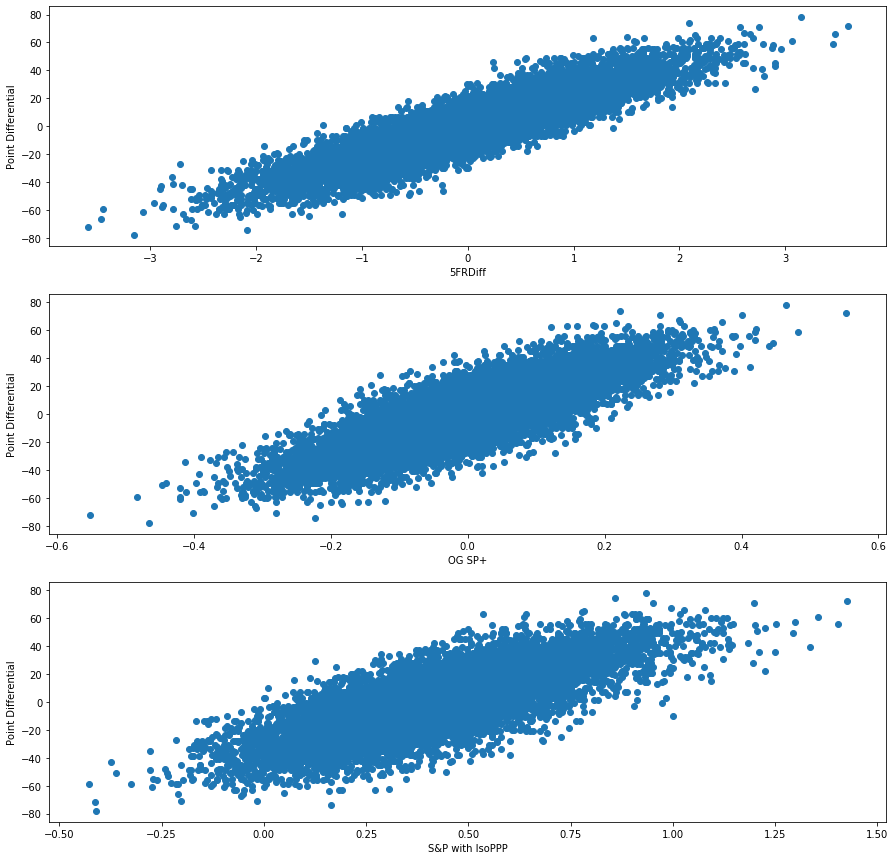

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [15]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912025,0.758809
S&PIsoPPPDiff,0.912025,1.000000,0.815979
PtsDiff,0.758809,0.815979,1.000000


In [16]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.04152,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.122680,-4.387538,-0.04152,-0.006633,0.012898,4.563898,-0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.42232,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.42232,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.26167,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553


In [17]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [18]:
# outliers

In [19]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.122680,-4.387538,-0.04152,-0.006633,0.012898,4.563898,-0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.42232,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.42232,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.26167,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553
5,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,0,-0.087917,6.578618,-0.26167,-0.059391,0.004509,5.268829,0.539235,0.607995,0.499553


In [20]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [21]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 22.47545x + 0.02410
Mean Pred Score: -0.3470131262501572
Pred Std Dev: 19.698341852839576
Mean Abs Error: 7.620793691559811
Mdn Abs Error: 6.218887273081065
R-squared: 0.7965143025403493



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.758851,0.580379,0.484289,0.798158,0.596664,0.619371,0.981929,0.521783,0.781529,-0.455108,-0.448353,0.732552,0.748829,0.240979,0.538037,0.884339,0.892790,0.892790
OffSRDiff,0.758851,1.000000,0.503339,0.280171,0.703765,0.370800,0.430488,0.753612,0.753595,0.724959,-0.278456,-0.179479,0.658896,0.763872,-0.052368,0.516209,0.857024,0.890317,0.890317
OffERDiff,0.580379,0.503339,1.000000,0.144422,0.518475,0.292436,0.332131,0.571419,0.373162,0.814194,-0.200485,-0.101880,0.764857,0.626420,0.549737,0.197520,0.498378,0.518497,0.518497
FPDiff,0.484289,0.280171,0.144422,1.000000,0.605810,0.103342,0.093678,0.454186,0.044170,0.238494,-0.261484,-0.369624,0.232728,0.228706,0.030956,0.265472,0.582041,0.576086,0.576086
OppRateDiff,0.798158,0.703765,0.518475,0.605810,1.000000,0.224654,0.230209,0.795085,0.299901,0.678840,-0.297219,-0.304918,0.607250,0.742938,0.131805,0.508075,0.810451,0.826715,0.826715
OppEffDiff,0.596664,0.370800,0.292436,0.103342,0.224654,1.000000,0.739918,0.587894,0.462014,0.431990,-0.310208,-0.312120,0.413421,0.367446,0.202781,0.319137,0.477302,0.475877,0.475877
OppPPDDiff,0.619371,0.430488,0.332131,0.093678,0.230209,0.739918,1.000000,0.622854,0.523051,0.483329,-0.336289,-0.310154,0.465365,0.384440,0.209652,0.347499,0.548563,0.551787,0.551787
PPDDiff,0.981929,0.753612,0.571419,0.454186,0.795085,0.587894,0.622854,1.000000,0.510894,0.769184,-0.444005,-0.440371,0.722635,0.728021,0.234068,0.537420,0.872903,0.881229,0.881229
OppSRDiff,0.521783,0.753595,0.373162,0.044170,0.299901,0.462014,0.523051,0.510894,1.000000,0.549138,-0.239676,-0.118263,0.510861,0.482332,-0.010914,0.356355,0.616280,0.642632,0.642632
YPPDiff,0.781529,0.724959,0.814194,0.238494,0.678840,0.431990,0.483329,0.769184,0.549138,1.000000,-0.319859,-0.193801,0.922092,0.797229,0.516141,0.435575,0.715704,0.740835,0.740835


In [22]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.746524,0.758851,0.732552,0.907628,0.484289,0.306104,0.884339,0.892790,0.892790
ActPts,0.746524,1.000000,0.578074,0.550756,0.690411,0.347647,0.212323,0.662180,0.670402,0.670402
Eff,0.758851,0.578074,1.000000,0.658896,0.797899,0.280171,0.078142,0.857024,0.890317,0.890317
Expl,0.732552,0.550756,0.658896,1.000000,0.710036,0.232728,0.083972,0.670454,0.692232,0.692232
FinDrv,0.907628,0.690411,0.797899,0.710036,1.000000,0.422010,0.239346,0.896661,0.913350,0.913350
FldPos,0.484289,0.347647,0.280171,0.232728,0.422010,1.000000,0.304787,0.582041,0.576086,0.576086
Trnovr,0.306104,0.212323,0.078142,0.083972,0.239346,0.304787,1.000000,0.480021,0.392473,0.392473
5FR,0.884339,0.662180,0.857024,0.670454,0.896661,0.582041,0.480021,1.000000,0.995249,0.995249
5FRDiff,0.892790,0.670402,0.890317,0.692232,0.913350,0.576086,0.392473,0.995249,1.000000,1.000000
PredPtsDiff,0.892790,0.670402,0.890317,0.692232,0.913350,0.576086,0.392473,0.995249,1.000000,1.000000


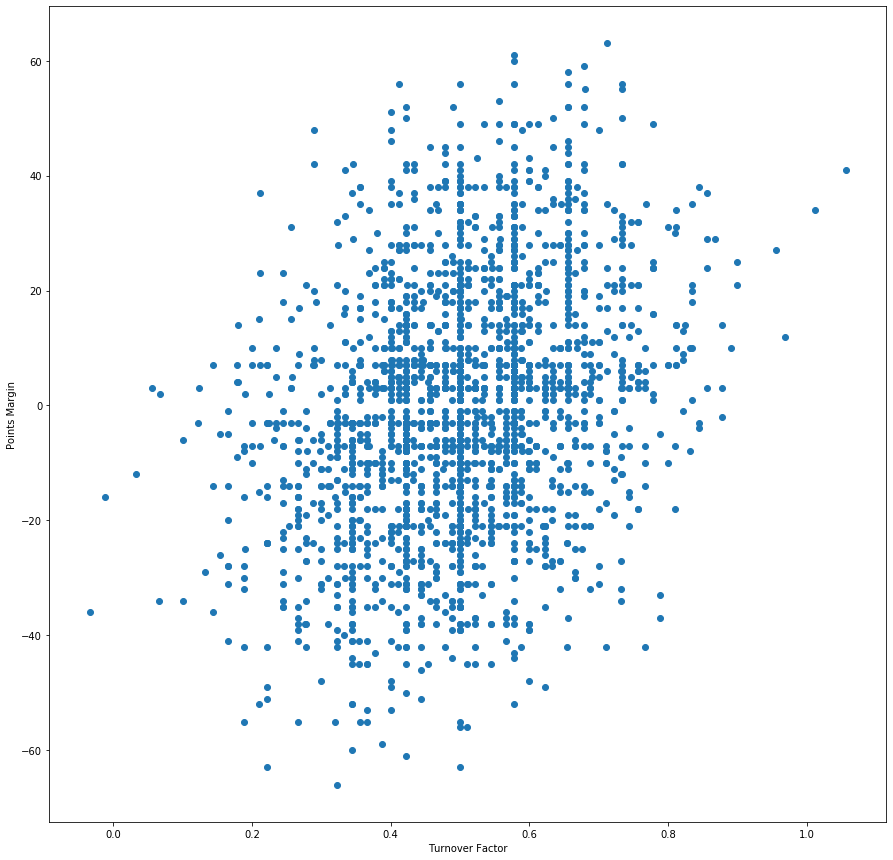

In [23]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

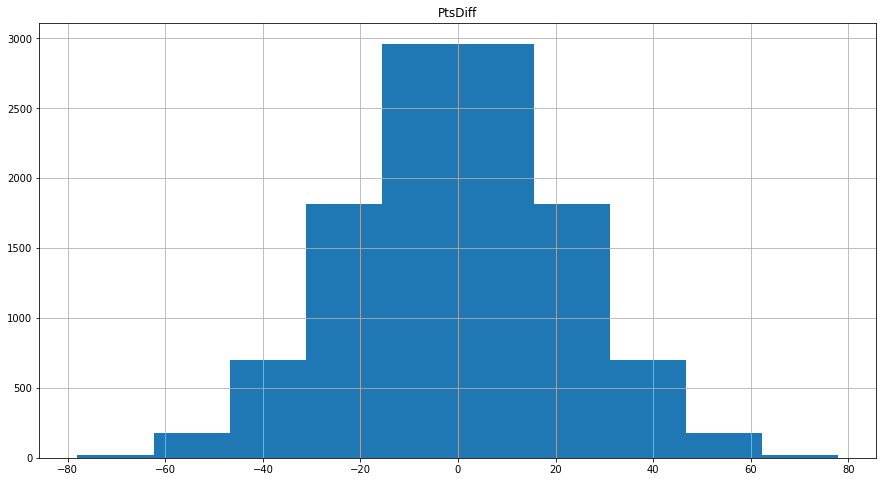

In [24]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

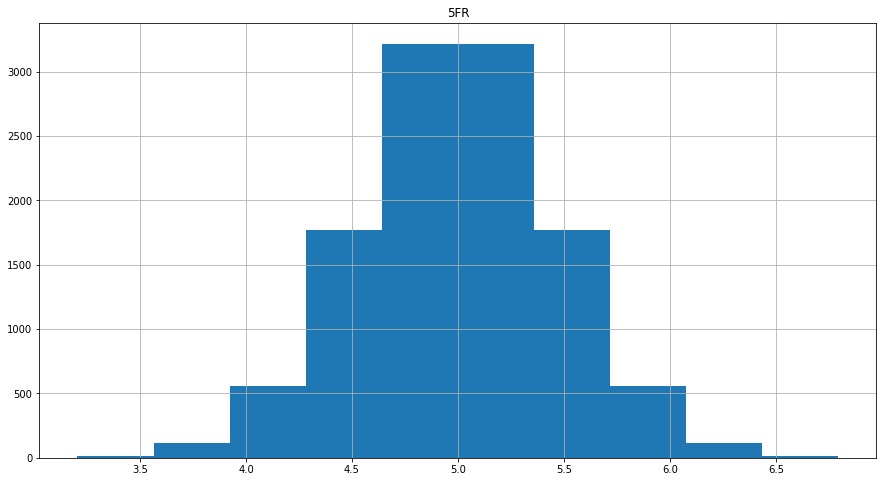

In [25]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

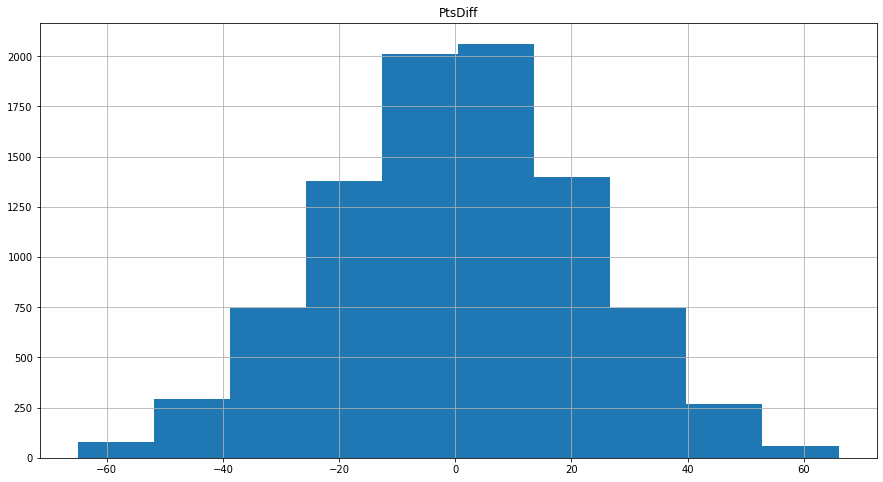

In [26]:
train_data.hist(column='PtsDiff', figsize=(15,8));

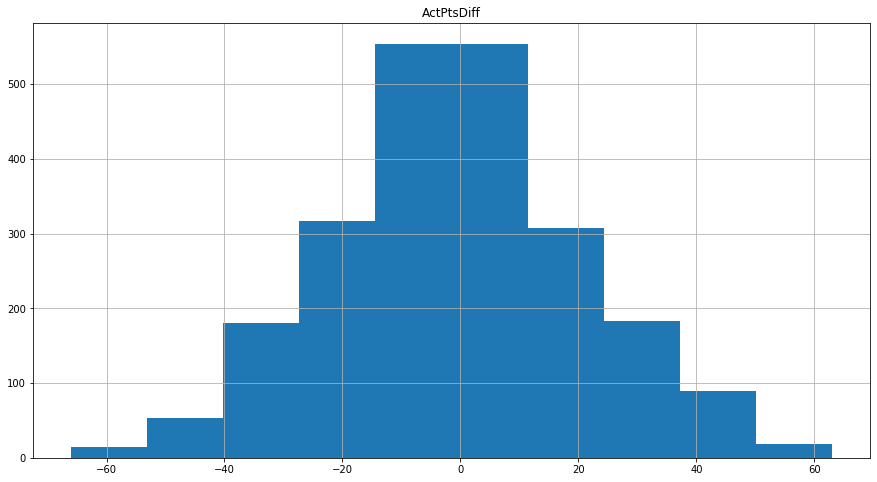

In [27]:
test.hist(column='ActPtsDiff', figsize=(15,8));

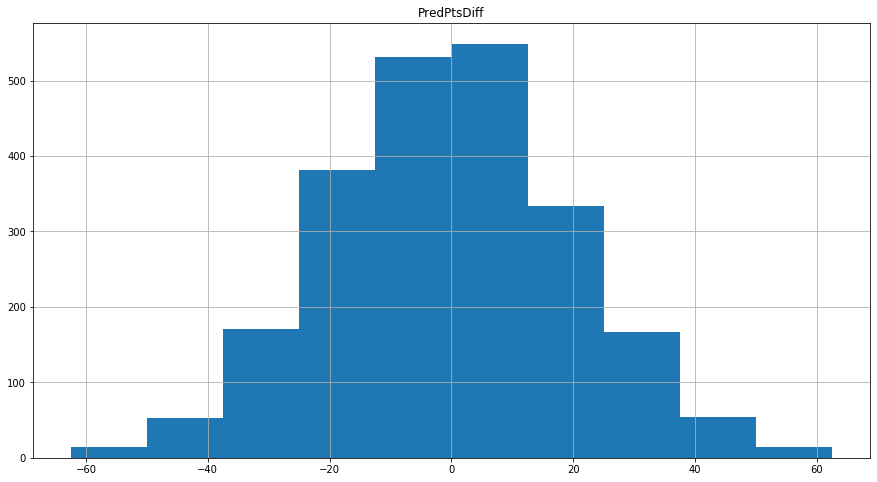

In [28]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [29]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [30]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -5.0 (exact value: -4.5985310762040665)
Z score: -0.21583126040332373
Win Prob for Virginia Tech: 41.46%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [31]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -17.0 (exact value: -16.587526555019718)
Z score: -0.8244609394078741
Win Prob for Georgia Tech: 20.48%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.630449,-0.739101
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.369551,0.739101


In [32]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -7.0 (exact value: -6.721745438979204)
Z score: -0.3236177115999289
Win Prob for Georgia Tech: 37.31%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.150071,0.300143
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.849929,-0.300143


In [33]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 6.0 (exact value: 5.944117013154982)
Z score: 0.31937358922919973
Win Prob for Mississippi State: 62.53%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.8683,-0.263399
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.1317,0.263399


In [34]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -8.0 (exact value: -8.373746755621838)
Z score: -0.4074827053635787
Win Prob for Texas A&M: 34.18%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.186823,0.373645
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.813177,-0.373645


In [35]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.943242,13,12.0,1.0
2,Clemson,0.936744,13,12.0,1.0
3,Alabama,0.920446,12,11.0,1.0
4,LSU,0.914202,13,12.0,1.0
5,Wisconsin,0.863877,13,11.0,2.0
6,Utah,0.837512,13,11.0,2.0
7,Oregon,0.821236,13,11.0,2.0
8,Oklahoma,0.820010,13,11.0,2.0
9,Appalachian State,0.806720,13,10.0,3.0
10,Notre Dame,0.796857,12,10.0,2.0


In [36]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.453158,1.546842
21,Clemson,10.595645,2.404355
53,LSU,10.445838,2.554162
128,Wisconsin,9.483523,3.516477
2,Alabama,9.358000,2.642000
115,Utah,9.190070,3.809930
78,Oklahoma,8.941372,4.058628
3,Appalachian State,8.893568,4.106432
82,Oregon,8.788543,4.211457
56,Memphis,8.585853,4.414147


In [37]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.606624,1
1,Florida State,2012,5.456845,2
2,Fresno State,2012,5.371180,3
3,Arizona State,2012,5.339381,4
4,Oklahoma,2012,5.339329,5
5,Notre Dame,2012,5.326277,6
6,Georgia,2012,5.306892,7
7,BYU,2012,5.306499,8
8,Kansas State,2012,5.302395,9
9,Ohio State,2012,5.285753,10


In [38]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    team_games = stored_game_boxes[stored_game_boxes.Team == team].GameID.to_list()
    for idx, item in enumerate(team_games, start=1):
        box = stored_game_boxes[stored_game_boxes.GameID == item]
        opp = filter_opponents(box, team)
        opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323080349.0,Army,2012.0,Air Force,8.0
8,323150021.0,San Diego State,2012.0,Air Force,9.0
9,323212005.0,Hawai'i,2012.0,Air Force,10.0


In [39]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
        
#     print(grouped_by_year.get_group((team1, year))[:1].tail(4))
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.048123214551289456, -33.11185288962738]

In [40]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 ML / 5-5 ATS ------
    ['Miami','Louisiana Tech',6],
    ['Pittsburgh','Eastern Michigan',11],
    ['North Carolina','Temple',5],
    ['Michigan State','Wake Forest',3.5],
    ['Texas A&M', 'Oklahoma State', 7],
    ['Iowa', 'USC', 2.5],
    ['Air Force', 'Washington State', 3],
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Notre Dame', 'Iowa State', 4],
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Western Kentucky', 'Western Michigan', 3.5],
    ['Mississippi State', 'Louisville', 4],
    ['California', 'Illinois', 6.5],
    ['Florida','Virginia',14], # Orange Bowl
    ['Virginia Tech', 'Kentucky', 3],
    ['Arizona State', 'Florida State', 4],
    ['Navy', 'Kansas State', 2],
    ['Wyoming', 'Georgia State', 7],
    ['Utah', 'Texas', 7],
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    ['Ohio', 'Nevada', 7.5],
    ['Tulane', 'Southern Mississippi', 7],
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Miami,Louisiana Tech,6.0,9.908110,0.698680,True,Miami,Miami
0,Pittsburgh,Eastern Michigan,11.0,3.048469,0.568428,False,Pittsburgh,Eastern Michigan
0,North Carolina,Temple,5.0,-2.196212,0.462604,False,Temple,Temple
0,Michigan State,Wake Forest,3.5,14.759303,0.778424,True,Michigan State,Michigan State
0,Texas A&M,Oklahoma State,7.0,1.343685,0.534199,False,Texas A&M,Oklahoma State
0,Iowa,USC,2.5,3.499677,0.577413,True,Iowa,Iowa
0,Air Force,Washington State,3.0,2.255326,0.552551,False,Air Force,Washington State
0,Penn State,Memphis,7.0,-0.197404,0.503030,False,Memphis,Memphis
0,Notre Dame,Iowa State,4.0,8.495200,0.673241,True,Notre Dame,Notre Dame
0,LSU,Oklahoma,11.0,10.609027,0.710960,False,LSU,Oklahoma


In [41]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 7.0 (exact value: 6.555771364349913)
Z score: 0.3504246470169271
Win Prob for Virginia: 63.70%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.854693,-0.290614
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,5.145307,0.290614


In [42]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 13.0 (exact value: 12.61414321340602)
Z score: 0.657982100040963
Win Prob for North Carolina: 74.47%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,5.280084,0.560169
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.719916,-0.560169


In [43]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 15.0 (exact value: 15.200625175198008)
Z score: 0.789286652531463
Win Prob for Pittsburgh: 78.50%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.337625,0.675249
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.662375,-0.675249


In [44]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -8.0 (exact value: -8.204840608753404)
Z score: -0.3989080675524228
Win Prob for Auburn: 34.50%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,5.183065,0.36613
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.816935,-0.36613


In [45]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 27.0 (exact value: 27.347360052275974)
Z score: 1.4059240816015133
Win Prob for Georgia: 92.01%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.607847,1.215694
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.392153,-1.215694


In [46]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 21.0 (exact value: 20.566171844183014)
Z score: 1.0616723542859254
Win Prob for Clemson: 85.58%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 5.0 (exact value: 4.7176153661145905)
Z score: 0.25710938160181573
Win Prob for Georgia Tech: 60.15%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -14.0 (exact value: -13.628543644139581)
Z score: -0.6742461176230856
Win Prob for The Citadel: 25.01%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 27.0 (exact value: 27.06828953989123)
Z score: 1.391756873291819
Win Prob for Temple: 91.80%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 13.0 (exact value: 12.61414321340602)
Z score: 0.6579821000409

,GameID,Year,Team,Opponent,PredWinProb,PredMOV,ActualMOV,PostGameWinProb
0,401111653,2019,Georgia Tech,Clemson,18.939534,-16.990023,-38.0,14.419223
1,401112441,2019,Georgia Tech,South Florida,81.642756,17.417628,4.0,60.145283
2,401112452,2019,Georgia Tech,The Citadel,97.748163,39.134591,-3.0,74.992257
3,401112469,2019,Georgia Tech,Temple,45.004210,-2.126212,-22.0,8.199802
4,401112475,2019,Georgia Tech,North Carolina,51.894654,0.588851,-16.0,25.527482
5,401112480,2019,Georgia Tech,Duke,23.201897,-14.076389,-18.0,25.978456
6,401112488,2019,Georgia Tech,Miami,36.389363,-6.509398,7.0,20.483885
7,401112498,2019,Georgia Tech,Pittsburgh,38.054284,-6.336401,-10.0,21.497224
8,401112504,2019,Georgia Tech,Virginia,33.492540,-8.051430,-5.0,18.275474
9,401112511,2019,Georgia Tech,Virginia Tech,13.441863,-22.128340,-45.0,0.087184


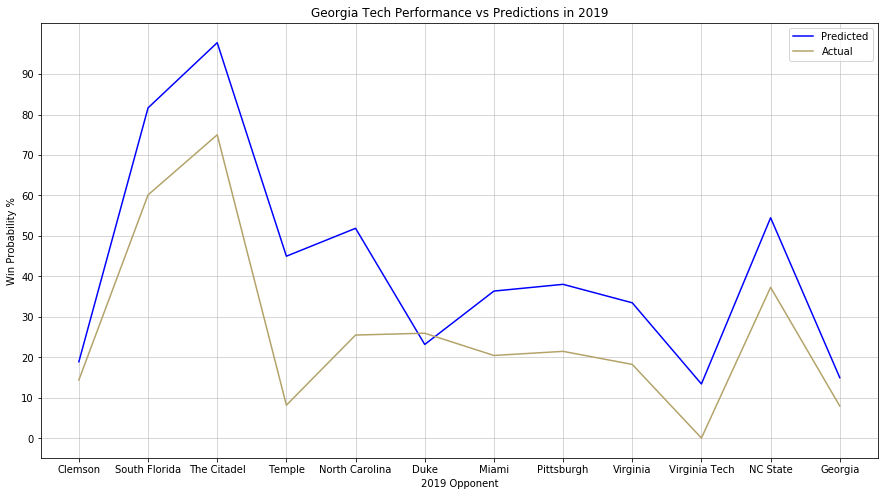

In [47]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

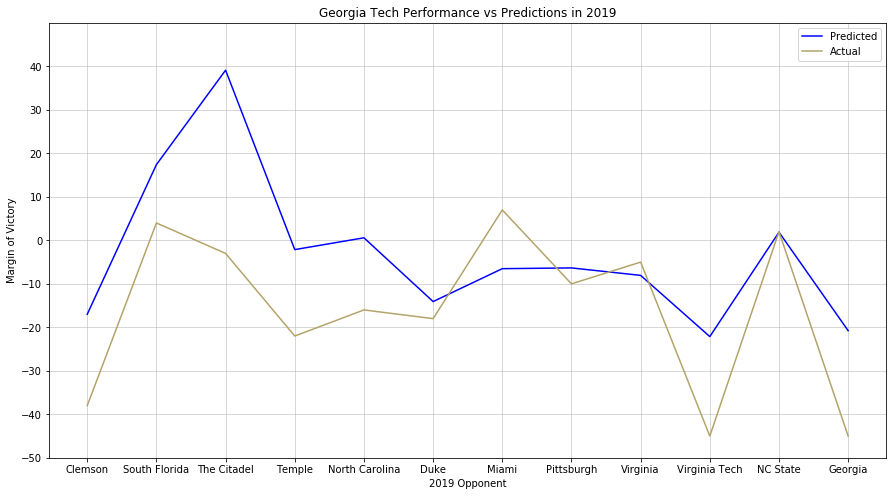

In [48]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 37.0 (exact value: 36.5837460361427)
Z score: 1.8748156285585618
Win Prob for Georgia Tech: 96.96%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 13.0 (exact value: 13.495113572973342)
Z score: 0.7027051719700008
Win Prob for South Florida: 75.89%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 11.0 (exact value: 11.086696093063567)
Z score: 0.5804401865259294
Win Prob for Pittsburgh: 71.92%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 31.0 (exact value: 30.714895611118084)
Z score: 1.5768793622033
Win Prob for Clemson: 94.26%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 40.0 (exact value: 39.982192537510386)
Z scor

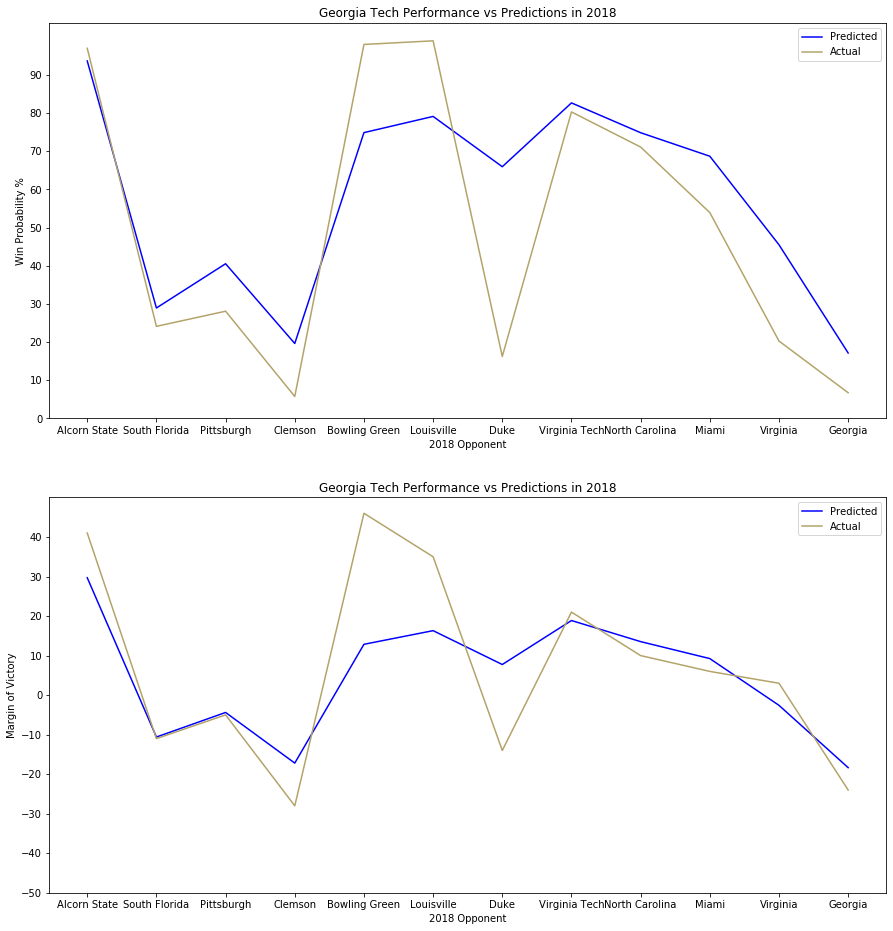

In [49]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

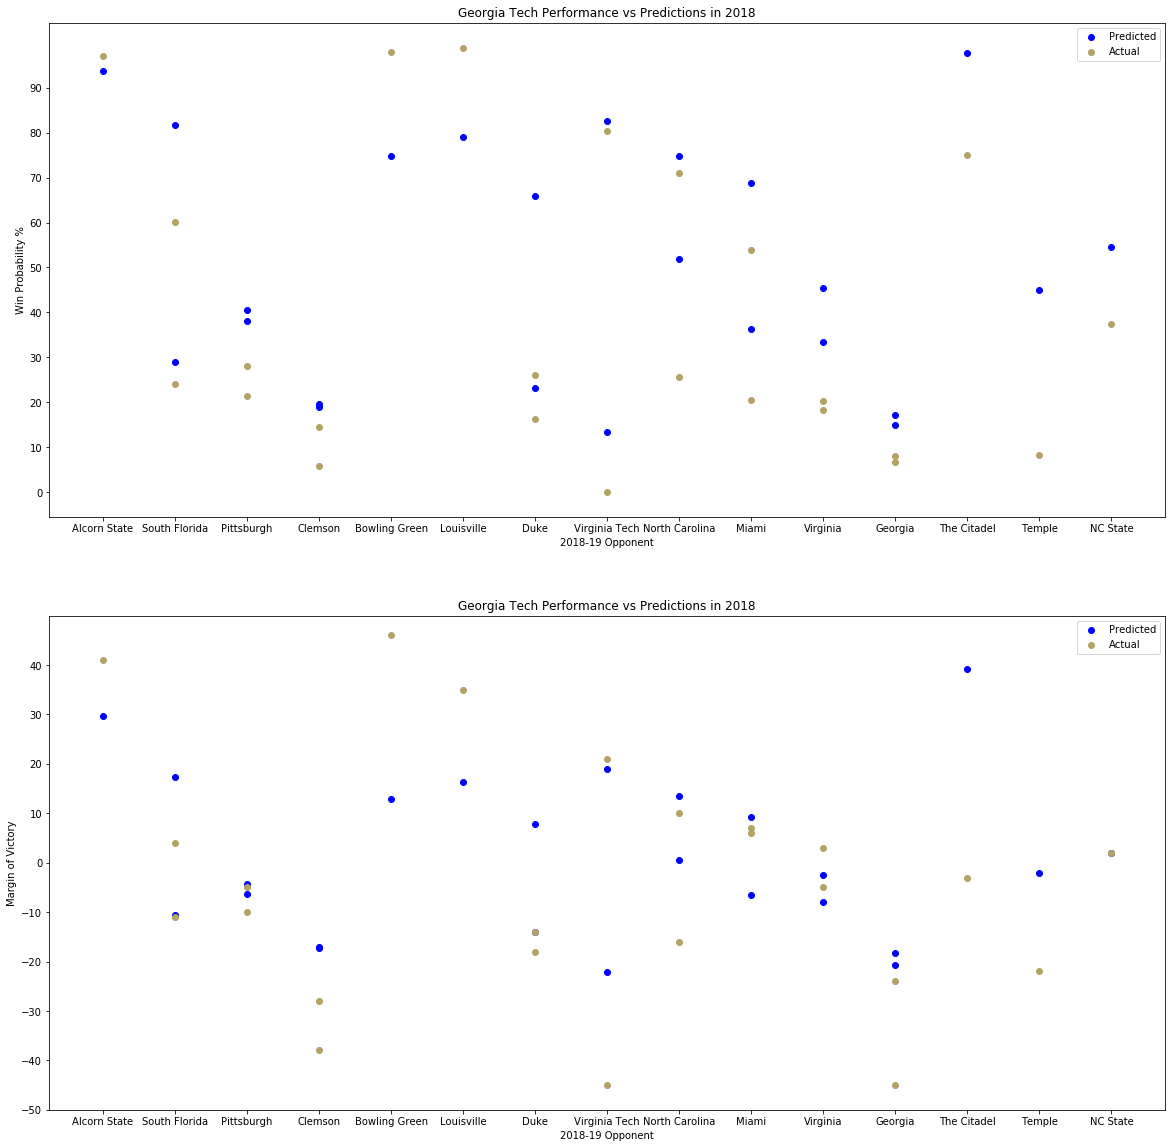

In [50]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [51]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.581310,0.523315,0.435028,0.365191,0.286904,0.285329,0.383764
2013,0.581310,1.000000,0.555835,0.369550,0.250899,0.232639,0.179753,0.281026
2014,0.523315,0.555835,1.000000,0.559955,0.460823,0.287926,0.281157,0.359910
2015,0.435028,0.369550,0.559955,1.000000,0.642715,0.446838,0.345127,0.368099
2016,0.365191,0.250899,0.460823,0.642715,1.000000,0.567064,0.409997,0.581482
2017,0.286904,0.232639,0.287926,0.446838,0.567064,1.000000,0.602075,0.539130
2018,0.285329,0.179753,0.281157,0.345127,0.409997,0.602075,1.000000,0.583893
2019,0.383764,0.281026,0.359910,0.368099,0.581482,0.539130,0.583893,1.000000


In [52]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["Gardner-Webb","UCF","Duke","Miami","Virginia","North Carolina","Pittsburgh","Syracuse","Virginia Tech","Clemson","Notre Dame","Georgia"],
    "Site" : ["Home","Home","Home","Home","Home","Away","Away","Away","Away","Home","Neutral","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Gardner-Webb,Home,95.336002,32.713580
1,2020,Georgia Tech,UCF,Home,28.206436,-11.707438
2,2020,Georgia Tech,Duke,Home,38.610936,-6.049170
3,2020,Georgia Tech,Miami,Home,26.277874,-12.851562
4,2020,Georgia Tech,Virginia,Home,27.123529,-12.344904
5,2020,Georgia Tech,North Carolina,Away,37.268577,-6.744017
6,2020,Georgia Tech,Pittsburgh,Away,38.981026,-5.858877
7,2020,Georgia Tech,Syracuse,Away,38.804693,-5.949478
8,2020,Georgia Tech,Virginia Tech,Away,28.751031,-11.391338
9,2020,Georgia Tech,Clemson,Home,13.883676,-21.730754


In [53]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)